<a href="https://colab.research.google.com/github/yasinunsal/INM706/blob/main/FasterRCNN_112_112_faster_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
!ls

'Copy of FasterRCNN_112_112_mobilenet_v3_large_320_fpn.ipynb'
'Copy of INM707-Lab7-REINFORCE.ipynb'
'Copy of INM707-Lab8-DoubleDQN.ipynb'
'Copy of INM707-Lab9-AC-PPO.ipynb'
 FasterRCNN_112_112_faster_weights_adam.ipynb
 FasterRCNN_112_112_faster_weights.ipynb
 FasterRCNN_config.ipynb
 FasterRCNN.ipynb
 FrCNN_config.ipynb
 fruit-images-for-object-detection
 INFERECE_INM705Lab3_object_dection.ipynb
 Inference_Load_Checkpoints.ipynb
 INM705
'INM705_lab1_showcase (1).ipynb'
 INM705_lab1_showcase.ipynb
'INM705_W7 - Graph Networks.ipynb'
 INM706_CW_from_PyCharm.ipynb
 INM706_W7_Bert
 INM707-Lab6
 Lab4_FCN_MASK_RCNN_Inference.ipynb
'Load of FasterRCNN checkpoint.ipynb'
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
 wandb


In [56]:
%cd /content/drive/MyDrive/Colab\ Notebooks
!ls


/content/drive/MyDrive/Colab Notebooks
'Copy of FasterRCNN_112_112_mobilenet_v3_large_320_fpn.ipynb'
'Copy of INM707-Lab7-REINFORCE.ipynb'
'Copy of INM707-Lab8-DoubleDQN.ipynb'
'Copy of INM707-Lab9-AC-PPO.ipynb'
 FasterRCNN_112_112_faster_weights_adam.ipynb
 FasterRCNN_112_112_faster_weights.ipynb
 FasterRCNN_config.ipynb
 FasterRCNN.ipynb
 FrCNN_config.ipynb
 fruit-images-for-object-detection
 INFERECE_INM705Lab3_object_dection.ipynb
 Inference_Load_Checkpoints.ipynb
 INM705
'INM705_lab1_showcase (1).ipynb'
 INM705_lab1_showcase.ipynb
'INM705_W7 - Graph Networks.ipynb'
 INM706_CW_from_PyCharm.ipynb
 INM706_W7_Bert
 INM707-Lab6
 Lab4_FCN_MASK_RCNN_Inference.ipynb
'Load of FasterRCNN checkpoint.ipynb'
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
 wandb


In [57]:
!pip install -q torch_snippets
!pip install wandb -qU
from torch_snippets import *
import torch
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
import numpy as np
import wandb
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)



cuda

In [58]:
# get parameters from config file
import yaml

def read_settings(config_path):
    with open(config_path, 'r') as file:
        settings = yaml.safe_load(file)
    return settings


# Read settings from the YAML file
config_path = 'fruit-images-for-object-detection/config.yaml'
settings = read_settings(config_path)

path_settings = settings.get('path_settings', {})
model_settings = settings.get('model', {})
train_settings = settings.get('train', {})


# Assign Parameters
root = path_settings['train_root']
val_root = path_settings['val_root']

epochs = train_settings['epochs']
batch_size_train = train_settings['batch_size_train']
batch_size_val = train_settings['batch_size_val']
learning_rate = train_settings['learning_rate']
weight_decay = train_settings['weight_decay']

# Hyperparameters
optimizer_pars = {'lr': learning_rate, 'weight_decay': weight_decay }


checkpoint_file = path_settings['checkpoint_root'] + f"{model_settings['backbone']}_{model_settings['optimizer']}_lr_{learning_rate}_CKPT.pth"
print(checkpoint_file)

fruit-images-for-object-detection/checkpoints/MOBILENET_ADAM_lr_1e-05_CKPT.pth

In [59]:
def save_checkpoint(epoch, model, model_name, optimizer, optimizer_name):
    ckpt = {'epoch': epoch, 'model_weights': model.state_dict(), 'optimizer_state': optimizer.state_dict()}
    checkpoint_path = path_settings['checkpoint_root'] + f"{model_name}_OPT_{optimizer_name}_CKPT.pth"
    torch.save(ckpt, checkpoint_path)


In [60]:
# we have four labels
labels = ['background', 'orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

In [61]:

log_name = f"FRCNN_{model_settings['backbone']}_{model_settings['optimizer']}_lr_{optimizer_pars['lr']}_weight_decay_{optimizer_pars['weight_decay']}"
wandb.login()
wandb.init(project='INM706_CW', name=log_name )

In [62]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.to(device).float()

class FruitsDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        w = train_settings['image_size']
        h = train_settings['image_size']
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h), resample=Image.BILINEAR))/255.
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
        target = {}
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))


tr_ds = FruitsDataset()
tr_dl = DataLoader(tr_ds, batch_size=batch_size_train, shuffle=True, collate_fn=tr_ds.collate_fn)

val_ds = FruitsDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=batch_size_val, shuffle=True, collate_fn=val_ds.collate_fn)


In [63]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights as faster_weights

def get_model():
    if model_settings['backbone'] == "RESNET":
      model = models.detection.fasterrcnn_resnet50_fpn(weights=faster_weights.DEFAULT)
    elif model_settings['backbone'] == "MOBILENET":
      model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, progress=True)


    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model



# test the model
imgs, targets = next(iter(tr_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
model(imgs, targets)


{'loss_classifier': tensor(1.5956, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.9912, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0330, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)}

In [64]:
model = get_model().to(device)
if model_settings['optimizer'] == 'SGD':
  optim = torch.optim.SGD(model.parameters(), **optimizer_pars)
else:
  optim = torch.optim.Adam(model.parameters(), **optimizer_pars)

def train_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optim.step()


    return loss, losses

@torch.no_grad()
def validate_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses





EPOCH: 0.017  trn_loss: 2.847  trn_loc_loss: 1.516  trn_regr_loss: 1.303  trn_loss_objectness: 0.018  trn_loss_rpn_box_reg: 0.010  (0.21s - 1286.35s remaining)
EPOCH: 0.033  trn_loss: 2.895  trn_loc_loss: 1.487  trn_regr_loss: 1.371  trn_loss_objectness: 0.027  trn_loss_rpn_box_reg: 0.010  (0.34s - 1031.74s remaining)
EPOCH: 0.050  trn_loss: 2.694  trn_loc_loss: 1.476  trn_regr_loss: 1.171  trn_loss_objectness: 0.039  trn_loss_rpn_box_reg: 0.007  (0.47s - 937.67s remaining)
EPOCH: 0.067  trn_loss: 2.408  trn_loc_loss: 1.367  trn_regr_loss: 1.016  trn_loss_objectness: 0.023  trn_loss_rpn_box_reg: 0.002  (0.58s - 876.17s remaining)
EPOCH: 0.083  trn_loss: 2.486  trn_loc_loss: 1.362  trn_regr_loss: 1.072  trn_loss_objectness: 0.037  trn_loss_rpn_box_reg: 0.015  (0.71s - 857.11s remaining)
EPOCH: 0.100  trn_loss: 2.594  trn_loc_loss: 1.307  trn_regr_loss: 1.271  trn_loss_objectness: 0.014  trn_loss_rpn_box_reg: 0.002  (0.83s - 825.92s remaining)
EPOCH: 0.117  trn_loss: 3.143  trn_loc_loss:

Loss=2.2424 in Epoch=0

EPOCH: 1.000  trn_loss_objectness: 0.028  trn_loss_rpn_box_reg: 0.006  trn_loss: 2.247  trn_loc_loss: 1.003  trn_regr_loss: 1.210  (7.82s - 774.58s remaining)
EPOCH: 1.017  trn_loss: 1.784  trn_loc_loss: 0.769  trn_regr_loss: 0.972  trn_loss_objectness: 0.034  trn_loss_rpn_box_reg: 0.009  (7.95s - 773.70s remaining)
EPOCH: 1.033  trn_loss: 2.538  trn_loc_loss: 0.861  trn_regr_loss: 1.663  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.007  (8.09s - 774.92s remaining)
EPOCH: 1.050  trn_loss: 2.536  trn_loc_loss: 1.015  trn_regr_loss: 1.506  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.003  (8.20s - 773.18s remaining)
EPOCH: 1.067  trn_loss: 2.076  trn_loc_loss: 0.762  trn_regr_loss: 1.282  trn_loss_objectness: 0.025  trn_loss_rpn_box_reg: 0.007  (8.36s - 775.35s remaining)
EPOCH: 1.083  trn_loss: 1.877  trn_loc_loss: 0.691  trn_regr_loss: 1.142  trn_loss_objectness: 0.035  trn_loss_rpn_box_reg: 0.009  (8.53s - 779.19s remaining)
EPOCH: 1.100  trn_loss: 1.999  trn_loc_loss: 0

Loss=1.8312 in Epoch=1

EPOCH: 2.000  trn_loss_objectness: 0.018  trn_loss_rpn_box_reg: 0.005  trn_loss: 1.837  trn_loc_loss: 0.630  trn_regr_loss: 1.182  (15.68s - 768.19s remaining)
EPOCH: 2.017  trn_loss: 1.228  trn_loc_loss: 0.383  trn_regr_loss: 0.823  trn_loss_objectness: 0.017  trn_loss_rpn_box_reg: 0.004  (15.81s - 768.33s remaining)
EPOCH: 2.033  trn_loss: 1.534  trn_loc_loss: 0.425  trn_regr_loss: 1.097  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.003  (16.09s - 775.33s remaining)
EPOCH: 2.050  trn_loss: 1.199  trn_loc_loss: 0.365  trn_regr_loss: 0.829  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.002  (16.26s - 776.76s remaining)
EPOCH: 2.067  trn_loss: 2.107  trn_loc_loss: 0.390  trn_regr_loss: 1.705  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.008  (16.42s - 778.20s remaining)
EPOCH: 2.083  trn_loss: 1.372  trn_loc_loss: 0.405  trn_regr_loss: 0.936  trn_loss_objectness: 0.028  trn_loss_rpn_box_reg: 0.003  (16.52s - 776.49s remaining)
EPOCH: 2.100  trn_loss: 1.646  trn_loc_l

Loss=1.4891 in Epoch=2

EPOCH: 3.000  trn_loss_objectness: 0.015  trn_loss_rpn_box_reg: 0.005  trn_loss: 1.502  trn_loc_loss: 0.457  trn_regr_loss: 1.025  (23.58s - 762.32s remaining)
EPOCH: 3.017  trn_loss: 1.133  trn_loc_loss: 0.338  trn_regr_loss: 0.777  trn_loss_objectness: 0.015  trn_loss_rpn_box_reg: 0.003  (23.71s - 762.35s remaining)
EPOCH: 3.033  trn_loss: 0.816  trn_loc_loss: 0.332  trn_regr_loss: 0.470  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.002  (23.84s - 762.03s remaining)
EPOCH: 3.050  trn_loss: 1.559  trn_loc_loss: 0.482  trn_regr_loss: 1.045  trn_loss_objectness: 0.026  trn_loss_rpn_box_reg: 0.006  (23.94s - 761.13s remaining)
EPOCH: 3.067  trn_loss: 0.977  trn_loc_loss: 0.458  trn_regr_loss: 0.495  trn_loss_objectness: 0.023  trn_loss_rpn_box_reg: 0.001  (24.05s - 760.19s remaining)
EPOCH: 3.083  trn_loss: 1.057  trn_loc_loss: 0.266  trn_regr_loss: 0.786  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.002  (24.33s - 764.62s remaining)
EPOCH: 3.100  trn_loss: 1.189  trn_loc_l

Loss=1.3048 in Epoch=3

EPOCH: 4.000  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.004  trn_loss: 1.294  trn_loc_loss: 0.390  trn_regr_loss: 0.887  (31.42s - 754.01s remaining)
EPOCH: 4.017  trn_loss: 1.324  trn_loc_loss: 0.333  trn_regr_loss: 0.979  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.006  (31.55s - 754.01s remaining)
EPOCH: 4.033  trn_loss: 1.225  trn_loc_loss: 0.438  trn_regr_loss: 0.770  trn_loss_objectness: 0.011  trn_loss_rpn_box_reg: 0.006  (31.84s - 757.56s remaining)
EPOCH: 4.050  trn_loss: 1.651  trn_loc_loss: 0.373  trn_regr_loss: 1.269  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.006  (31.95s - 756.84s remaining)
EPOCH: 4.067  trn_loss: 1.204  trn_loc_loss: 0.406  trn_regr_loss: 0.775  trn_loss_objectness: 0.016  trn_loss_rpn_box_reg: 0.008  (32.06s - 756.25s remaining)
EPOCH: 4.083  trn_loss: 1.082  trn_loc_loss: 0.314  trn_regr_loss: 0.751  trn_loss_objectness: 0.013  trn_loss_rpn_box_reg: 0.004  (32.16s - 755.50s remaining)
EPOCH: 4.100  trn_loss: 1.397  trn_loc_l

Loss=1.1789 in Epoch=4

EPOCH: 5.000  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.004  trn_loss: 1.192  trn_loc_loss: 0.355  trn_regr_loss: 0.823  (39.42s - 748.89s remaining)
EPOCH: 5.017  trn_loss: 1.215  trn_loc_loss: 0.418  trn_regr_loss: 0.788  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.003  (39.52s - 748.32s remaining)
EPOCH: 5.033  trn_loss: 1.420  trn_loc_loss: 0.352  trn_regr_loss: 1.061  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.005  (39.63s - 747.69s remaining)
EPOCH: 5.050  trn_loss: 0.752  trn_loc_loss: 0.288  trn_regr_loss: 0.460  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (39.74s - 747.27s remaining)
EPOCH: 5.067  trn_loss: 0.804  trn_loc_loss: 0.237  trn_regr_loss: 0.564  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (39.84s - 746.53s remaining)
EPOCH: 5.083  trn_loss: 0.828  trn_loc_loss: 0.341  trn_regr_loss: 0.484  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (39.95s - 746.03s remaining)
EPOCH: 5.100  trn_loss: 1.059  trn_loc_l

Loss=1.0620 in Epoch=5

EPOCH: 6.000  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.004  trn_loss: 1.056  trn_loc_loss: 0.319  trn_regr_loss: 0.725  (47.09s - 737.70s remaining)
EPOCH: 6.017  trn_loss: 1.256  trn_loc_loss: 0.311  trn_regr_loss: 0.930  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.006  (47.27s - 738.31s remaining)
EPOCH: 6.033  trn_loss: 0.722  trn_loc_loss: 0.281  trn_regr_loss: 0.417  trn_loss_objectness: 0.021  trn_loss_rpn_box_reg: 0.003  (47.57s - 740.93s remaining)
EPOCH: 6.050  trn_loss: 0.827  trn_loc_loss: 0.311  trn_regr_loss: 0.504  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.003  (47.68s - 740.47s remaining)
EPOCH: 6.067  trn_loss: 1.083  trn_loc_loss: 0.330  trn_regr_loss: 0.740  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.007  (47.82s - 740.44s remaining)
EPOCH: 6.083  trn_loss: 0.579  trn_loc_loss: 0.255  trn_regr_loss: 0.312  trn_loss_objectness: 0.010  trn_loss_rpn_box_reg: 0.001  (47.93s - 739.90s remaining)
EPOCH: 6.100  trn_loss: 0.757  trn_loc_l

Loss=0.9940 in Epoch=6

EPOCH: 7.000  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.004  trn_loss: 0.992  trn_loc_loss: 0.290  trn_regr_loss: 0.691  (55.08s - 731.84s remaining)
EPOCH: 7.017  trn_loss: 0.997  trn_loc_loss: 0.205  trn_regr_loss: 0.789  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (55.24s - 732.06s remaining)
EPOCH: 7.033  trn_loss: 0.772  trn_loc_loss: 0.247  trn_regr_loss: 0.510  trn_loss_objectness: 0.013  trn_loss_rpn_box_reg: 0.003  (55.35s - 731.56s remaining)
EPOCH: 7.050  trn_loss: 1.038  trn_loc_loss: 0.232  trn_regr_loss: 0.803  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (55.62s - 733.27s remaining)
EPOCH: 7.067  trn_loss: 1.140  trn_loc_loss: 0.256  trn_regr_loss: 0.880  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (55.74s - 733.09s remaining)
EPOCH: 7.083  trn_loss: 1.020  trn_loc_loss: 0.349  trn_regr_loss: 0.655  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.004  (55.87s - 732.87s remaining)
EPOCH: 7.100  trn_loss: 0.625  trn_loc_l

Loss=0.9108 in Epoch=7

EPOCH: 8.000  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.003  trn_loss: 0.918  trn_loc_loss: 0.277  trn_regr_loss: 0.631  (63.00s - 724.45s remaining)
EPOCH: 8.017  trn_loss: 1.302  trn_loc_loss: 0.305  trn_regr_loss: 0.988  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.007  (63.11s - 724.15s remaining)
EPOCH: 8.033  trn_loss: 0.746  trn_loc_loss: 0.261  trn_regr_loss: 0.482  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (63.23s - 723.85s remaining)
EPOCH: 8.050  trn_loss: 0.405  trn_loc_loss: 0.142  trn_regr_loss: 0.262  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (63.34s - 723.47s remaining)
EPOCH: 8.067  trn_loss: 1.055  trn_loc_loss: 0.339  trn_regr_loss: 0.711  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (63.43s - 722.91s remaining)
EPOCH: 8.083  trn_loss: 0.768  trn_loc_loss: 0.190  trn_regr_loss: 0.573  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.002  (63.55s - 722.66s remaining)
EPOCH: 8.100  trn_loss: 0.711  trn_loc_l

Loss=0.8558 in Epoch=8

EPOCH: 9.000  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.003  trn_loss: 0.852  trn_loc_loss: 0.241  trn_regr_loss: 0.602  (70.65s - 714.32s remaining)
EPOCH: 9.017  trn_loss: 0.922  trn_loc_loss: 0.249  trn_regr_loss: 0.670  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.002  (70.79s - 714.27s remaining)
EPOCH: 9.033  trn_loss: 0.696  trn_loc_loss: 0.182  trn_regr_loss: 0.512  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (70.90s - 713.95s remaining)
EPOCH: 9.050  trn_loss: 0.763  trn_loc_loss: 0.207  trn_regr_loss: 0.553  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (71.03s - 713.79s remaining)
EPOCH: 9.067  trn_loss: 0.928  trn_loc_loss: 0.224  trn_regr_loss: 0.698  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.002  (71.14s - 713.53s remaining)
EPOCH: 9.083  trn_loss: 0.888  trn_loc_loss: 0.249  trn_regr_loss: 0.634  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.004  (71.26s - 713.23s remaining)
EPOCH: 9.100  trn_loss: 0.956  trn_loc_l

Loss=0.8107 in Epoch=9

EPOCH: 10.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.003  trn_loss: 0.815  trn_loc_loss: 0.235  trn_regr_loss: 0.572  (78.53s - 706.79s remaining)
EPOCH: 10.017  trn_loss: 0.472  trn_loc_loss: 0.085  trn_regr_loss: 0.385  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (78.67s - 706.75s remaining)
EPOCH: 10.033  trn_loss: 0.945  trn_loc_loss: 0.281  trn_regr_loss: 0.650  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.004  (78.78s - 706.44s remaining)
EPOCH: 10.050  trn_loss: 0.759  trn_loc_loss: 0.149  trn_regr_loss: 0.604  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.003  (78.95s - 706.58s remaining)
EPOCH: 10.067  trn_loss: 0.971  trn_loc_loss: 0.271  trn_regr_loss: 0.695  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.005  (79.04s - 706.12s remaining)
EPOCH: 10.083  trn_loss: 0.525  trn_loc_loss: 0.168  trn_regr_loss: 0.355  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (79.34s - 707.47s remaining)
EPOCH: 10.100  trn_loss: 0.797  tr

Loss=0.7736 in Epoch=10

EPOCH: 11.000  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.003  trn_loss: 0.770  trn_loc_loss: 0.221  trn_regr_loss: 0.541  (86.44s - 699.37s remaining)
EPOCH: 11.017  trn_loss: 0.421  trn_loc_loss: 0.172  trn_regr_loss: 0.240  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.002  (86.57s - 699.26s remaining)
EPOCH: 11.033  trn_loss: 0.603  trn_loc_loss: 0.220  trn_regr_loss: 0.381  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (86.88s - 700.54s remaining)
EPOCH: 11.050  trn_loss: 0.539  trn_loc_loss: 0.209  trn_regr_loss: 0.328  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (86.98s - 700.17s remaining)
EPOCH: 11.067  trn_loss: 1.056  trn_loc_loss: 0.331  trn_regr_loss: 0.715  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.005  (87.08s - 699.83s remaining)
EPOCH: 11.083  trn_loss: 0.555  trn_loc_loss: 0.202  trn_regr_loss: 0.338  trn_loss_objectness: 0.015  trn_loss_rpn_box_reg: 0.001  (87.21s - 699.61s remaining)
EPOCH: 11.100  trn_loss: 0.755  tr

Loss=0.7203 in Epoch=11

EPOCH: 12.000  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.003  trn_loss: 0.725  trn_loc_loss: 0.205  trn_regr_loss: 0.514  (94.25s - 691.14s remaining)
EPOCH: 12.017  trn_loss: 0.441  trn_loc_loss: 0.151  trn_regr_loss: 0.287  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (94.38s - 691.00s remaining)
EPOCH: 12.033  trn_loss: 0.518  trn_loc_loss: 0.215  trn_regr_loss: 0.295  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.001  (94.49s - 690.74s remaining)
EPOCH: 12.050  trn_loss: 0.675  trn_loc_loss: 0.159  trn_regr_loss: 0.513  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (94.60s - 690.49s remaining)
EPOCH: 12.067  trn_loss: 0.310  trn_loc_loss: 0.125  trn_regr_loss: 0.184  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (94.88s - 691.43s remaining)
EPOCH: 12.083  trn_loss: 0.563  trn_loc_loss: 0.181  trn_regr_loss: 0.371  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.003  (94.98s - 691.07s remaining)
EPOCH: 12.100  trn_loss: 0.838  tr

Loss=0.7006 in Epoch=12

EPOCH: 13.000  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.002  trn_loss: 0.697  trn_loc_loss: 0.195  trn_regr_loss: 0.496  (102.15s - 683.62s remaining)
EPOCH: 13.017  trn_loss: 0.571  trn_loc_loss: 0.186  trn_regr_loss: 0.375  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.004  (102.47s - 684.72s remaining)
EPOCH: 13.033  trn_loss: 0.465  trn_loc_loss: 0.142  trn_regr_loss: 0.322  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (102.58s - 684.46s remaining)
EPOCH: 13.050  trn_loss: 0.605  trn_loc_loss: 0.166  trn_regr_loss: 0.437  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (102.71s - 684.31s remaining)
EPOCH: 13.067  trn_loss: 0.391  trn_loc_loss: 0.150  trn_regr_loss: 0.239  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (102.82s - 684.05s remaining)
EPOCH: 13.083  trn_loss: 0.588  trn_loc_loss: 0.168  trn_regr_loss: 0.412  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.003  (102.93s - 683.80s remaining)
EPOCH: 13.100  trn_loss: 0.6

Loss=0.6455 in Epoch=13

EPOCH: 14.000  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.002  trn_loss: 0.654  trn_loc_loss: 0.186  trn_regr_loss: 0.462  (110.24s - 677.16s remaining)
EPOCH: 14.017  trn_loss: 0.589  trn_loc_loss: 0.142  trn_regr_loss: 0.443  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (110.37s - 677.05s remaining)
EPOCH: 14.033  trn_loss: 0.767  trn_loc_loss: 0.159  trn_regr_loss: 0.602  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.003  (110.49s - 676.83s remaining)
EPOCH: 14.050  trn_loss: 0.455  trn_loc_loss: 0.104  trn_regr_loss: 0.348  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (110.60s - 676.62s remaining)
EPOCH: 14.067  trn_loss: 0.950  trn_loc_loss: 0.303  trn_regr_loss: 0.643  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (110.84s - 677.12s remaining)
EPOCH: 14.083  trn_loss: 0.488  trn_loc_loss: 0.068  trn_regr_loss: 0.416  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (110.94s - 676.78s remaining)
EPOCH: 14.100  trn_loss: 0.4

Loss=0.6429 in Epoch=14

EPOCH: 15.000  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.002  trn_loss: 0.633  trn_loc_loss: 0.179  trn_regr_loss: 0.449  (118.09s - 669.15s remaining)
EPOCH: 15.017  trn_loss: 0.466  trn_loc_loss: 0.164  trn_regr_loss: 0.300  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (118.38s - 669.97s remaining)
EPOCH: 15.033  trn_loss: 0.685  trn_loc_loss: 0.212  trn_regr_loss: 0.468  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (118.48s - 669.64s remaining)
EPOCH: 15.050  trn_loss: 0.432  trn_loc_loss: 0.132  trn_regr_loss: 0.293  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.000  (118.63s - 669.61s remaining)
EPOCH: 15.067  trn_loss: 0.355  trn_loc_loss: 0.113  trn_regr_loss: 0.239  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.002  (118.73s - 669.28s remaining)
EPOCH: 15.083  trn_loss: 0.740  trn_loc_loss: 0.176  trn_regr_loss: 0.559  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.004  (119.12s - 670.65s remaining)
EPOCH: 15.100  trn_loss: 0.4

Loss=0.5910 in Epoch=15

EPOCH: 16.000  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.002  trn_loss: 0.601  trn_loc_loss: 0.172  trn_regr_loss: 0.425  (125.98s - 661.40s remaining)
EPOCH: 16.017  trn_loss: 0.471  trn_loc_loss: 0.191  trn_regr_loss: 0.275  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (126.10s - 661.19s remaining)
EPOCH: 16.033  trn_loss: 0.862  trn_loc_loss: 0.243  trn_regr_loss: 0.615  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (126.20s - 660.93s remaining)
EPOCH: 16.050  trn_loss: 0.596  trn_loc_loss: 0.150  trn_regr_loss: 0.444  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (126.34s - 660.84s remaining)
EPOCH: 16.067  trn_loss: 0.520  trn_loc_loss: 0.172  trn_regr_loss: 0.346  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (126.48s - 660.72s remaining)
EPOCH: 16.083  trn_loss: 0.524  trn_loc_loss: 0.107  trn_regr_loss: 0.409  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.002  (126.58s - 660.42s remaining)
EPOCH: 16.100  trn_loss: 0.4

Loss=0.5895 in Epoch=16

EPOCH: 17.000  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  trn_loss: 0.585  trn_loc_loss: 0.164  trn_regr_loss: 0.416  (133.73s - 652.91s remaining)
EPOCH: 17.017  trn_loss: 0.853  trn_loc_loss: 0.187  trn_regr_loss: 0.655  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.006  (133.89s - 652.94s remaining)
EPOCH: 17.033  trn_loss: 0.538  trn_loc_loss: 0.218  trn_regr_loss: 0.318  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (134.02s - 652.80s remaining)
EPOCH: 17.050  trn_loss: 0.960  trn_loc_loss: 0.163  trn_regr_loss: 0.791  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.005  (134.17s - 652.76s remaining)
EPOCH: 17.067  trn_loss: 0.346  trn_loc_loss: 0.093  trn_regr_loss: 0.251  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (134.27s - 652.45s remaining)
EPOCH: 17.083  trn_loss: 0.632  trn_loc_loss: 0.187  trn_regr_loss: 0.438  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.003  (134.59s - 653.26s remaining)
EPOCH: 17.100  trn_loss: 0.3

Loss=0.5681 in Epoch=17

EPOCH: 18.000  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  trn_loss: 0.572  trn_loc_loss: 0.160  trn_regr_loss: 0.408  (141.60s - 645.05s remaining)
EPOCH: 18.017  trn_loss: 0.648  trn_loc_loss: 0.154  trn_regr_loss: 0.486  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.002  (141.74s - 645.00s remaining)
EPOCH: 18.033  trn_loss: 0.571  trn_loc_loss: 0.199  trn_regr_loss: 0.363  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.001  (142.02s - 645.50s remaining)
EPOCH: 18.050  trn_loss: 0.272  trn_loc_loss: 0.094  trn_regr_loss: 0.176  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (142.12s - 645.23s remaining)
EPOCH: 18.067  trn_loss: 0.644  trn_loc_loss: 0.198  trn_regr_loss: 0.436  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.003  (142.23s - 645.04s remaining)
EPOCH: 18.083  trn_loss: 1.000  trn_loc_loss: 0.144  trn_regr_loss: 0.854  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (142.38s - 644.99s remaining)
EPOCH: 18.100  trn_loss: 0.3

Loss=0.5390 in Epoch=18

EPOCH: 19.000  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  trn_loss: 0.535  trn_loc_loss: 0.156  trn_regr_loss: 0.376  (149.53s - 637.48s remaining)
EPOCH: 19.017  trn_loss: 0.300  trn_loc_loss: 0.042  trn_regr_loss: 0.252  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.000  (149.74s - 637.69s remaining)
EPOCH: 19.033  trn_loss: 0.317  trn_loc_loss: 0.087  trn_regr_loss: 0.230  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (149.87s - 637.55s remaining)
EPOCH: 19.050  trn_loss: 0.676  trn_loc_loss: 0.161  trn_regr_loss: 0.510  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (149.99s - 637.34s remaining)
EPOCH: 19.067  trn_loss: 0.537  trn_loc_loss: 0.207  trn_regr_loss: 0.328  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (150.11s - 637.19s remaining)
EPOCH: 19.083  trn_loss: 0.556  trn_loc_loss: 0.169  trn_regr_loss: 0.382  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.002  (150.38s - 637.66s remaining)
EPOCH: 19.100  trn_loss: 0.6

Loss=0.5316 in Epoch=19

EPOCH: 20.000  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  trn_loss: 0.532  trn_loc_loss: 0.151  trn_regr_loss: 0.377  (157.33s - 629.30s remaining)
EPOCH: 20.017  trn_loss: 0.487  trn_loc_loss: 0.189  trn_regr_loss: 0.293  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.002  (157.45s - 629.12s remaining)
EPOCH: 20.033  trn_loss: 0.381  trn_loc_loss: 0.141  trn_regr_loss: 0.238  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (157.73s - 629.60s remaining)
EPOCH: 20.050  trn_loss: 0.754  trn_loc_loss: 0.233  trn_regr_loss: 0.510  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.002  (157.84s - 629.38s remaining)
EPOCH: 20.067  trn_loss: 0.416  trn_loc_loss: 0.136  trn_regr_loss: 0.276  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (157.94s - 629.12s remaining)
EPOCH: 20.083  trn_loss: 0.437  trn_loc_loss: 0.128  trn_regr_loss: 0.307  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (158.03s - 628.85s remaining)
EPOCH: 20.100  trn_loss: 0.6

Loss=0.5089 in Epoch=20

EPOCH: 21.000  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  trn_loss: 0.511  trn_loc_loss: 0.144  trn_regr_loss: 0.363  (165.23s - 621.57s remaining)
EPOCH: 21.017  trn_loss: 0.283  trn_loc_loss: 0.124  trn_regr_loss: 0.154  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.001  (165.35s - 621.42s remaining)
EPOCH: 21.033  trn_loss: 0.618  trn_loc_loss: 0.144  trn_regr_loss: 0.470  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.003  (165.48s - 621.28s remaining)
EPOCH: 21.050  trn_loss: 0.805  trn_loc_loss: 0.170  trn_regr_loss: 0.632  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (165.59s - 621.06s remaining)
EPOCH: 21.067  trn_loss: 0.230  trn_loc_loss: 0.078  trn_regr_loss: 0.151  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (165.90s - 621.60s remaining)
EPOCH: 21.083  trn_loss: 0.241  trn_loc_loss: 0.056  trn_regr_loss: 0.183  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (166.00s - 621.36s remaining)
EPOCH: 21.100  trn_loss: 0.3

Loss=0.4964 in Epoch=21

EPOCH: 22.000  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  trn_loss: 0.498  trn_loc_loss: 0.137  trn_regr_loss: 0.357  (173.18s - 614.01s remaining)
EPOCH: 22.017  trn_loss: 0.254  trn_loc_loss: 0.074  trn_regr_loss: 0.176  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (173.30s - 613.84s remaining)
EPOCH: 22.033  trn_loss: 0.473  trn_loc_loss: 0.159  trn_regr_loss: 0.312  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.002  (173.68s - 614.57s remaining)
EPOCH: 22.050  trn_loss: 0.320  trn_loc_loss: 0.119  trn_regr_loss: 0.200  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (173.77s - 614.31s remaining)
EPOCH: 22.067  trn_loss: 0.352  trn_loc_loss: 0.134  trn_regr_loss: 0.214  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (173.88s - 614.10s remaining)
EPOCH: 22.083  trn_loss: 0.395  trn_loc_loss: 0.070  trn_regr_loss: 0.325  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (174.01s - 613.96s remaining)
EPOCH: 22.100  trn_loss: 0.3

Loss=0.4794 in Epoch=22

EPOCH: 23.000  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  trn_loss: 0.481  trn_loc_loss: 0.136  trn_regr_loss: 0.341  (181.12s - 606.36s remaining)
EPOCH: 23.017  trn_loss: 0.615  trn_loc_loss: 0.145  trn_regr_loss: 0.468  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (181.26s - 606.26s remaining)
EPOCH: 23.033  trn_loss: 0.365  trn_loc_loss: 0.115  trn_regr_loss: 0.247  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (181.36s - 606.01s remaining)
EPOCH: 23.050  trn_loss: 0.493  trn_loc_loss: 0.172  trn_regr_loss: 0.319  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (181.64s - 606.37s remaining)
EPOCH: 23.067  trn_loss: 0.401  trn_loc_loss: 0.090  trn_regr_loss: 0.309  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (181.74s - 606.15s remaining)
EPOCH: 23.083  trn_loss: 0.494  trn_loc_loss: 0.129  trn_regr_loss: 0.360  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.001  (181.86s - 605.98s remaining)
EPOCH: 23.100  trn_loss: 0.4

Loss=0.4621 in Epoch=23

EPOCH: 24.000  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.464  trn_loc_loss: 0.128  trn_regr_loss: 0.332  (188.97s - 598.42s remaining)
EPOCH: 24.017  trn_loss: 0.624  trn_loc_loss: 0.145  trn_regr_loss: 0.475  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (189.15s - 598.43s remaining)
EPOCH: 24.033  trn_loss: 0.724  trn_loc_loss: 0.173  trn_regr_loss: 0.548  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (189.27s - 598.25s remaining)
EPOCH: 24.050  trn_loss: 0.416  trn_loc_loss: 0.098  trn_regr_loss: 0.315  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (189.36s - 598.01s remaining)
EPOCH: 24.067  trn_loss: 0.767  trn_loc_loss: 0.172  trn_regr_loss: 0.586  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.003  (189.46s - 597.76s remaining)
EPOCH: 24.083  trn_loss: 0.242  trn_loc_loss: 0.096  trn_regr_loss: 0.144  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.000  (189.72s - 598.06s remaining)
EPOCH: 24.100  trn_loss: 0.3

Loss=0.4589 in Epoch=24

EPOCH: 25.000  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.459  trn_loc_loss: 0.124  trn_regr_loss: 0.332  (196.96s - 590.87s remaining)
EPOCH: 25.017  trn_loss: 0.295  trn_loc_loss: 0.106  trn_regr_loss: 0.183  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.001  (197.29s - 591.34s remaining)
EPOCH: 25.033  trn_loss: 0.566  trn_loc_loss: 0.121  trn_regr_loss: 0.439  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.003  (197.41s - 591.17s remaining)
EPOCH: 25.050  trn_loss: 0.410  trn_loc_loss: 0.108  trn_regr_loss: 0.300  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (197.51s - 590.96s remaining)
EPOCH: 25.067  trn_loss: 0.396  trn_loc_loss: 0.149  trn_regr_loss: 0.245  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (197.64s - 590.81s remaining)
EPOCH: 25.083  trn_loss: 0.398  trn_loc_loss: 0.121  trn_regr_loss: 0.276  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (197.74s - 590.59s remaining)
EPOCH: 25.100  trn_loss: 0.3

Loss=0.4499 in Epoch=25

EPOCH: 26.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.451  trn_loc_loss: 0.122  trn_regr_loss: 0.326  (204.93s - 583.26s remaining)
EPOCH: 26.017  trn_loss: 0.422  trn_loc_loss: 0.121  trn_regr_loss: 0.299  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (205.09s - 583.20s remaining)
EPOCH: 26.033  trn_loss: 0.481  trn_loc_loss: 0.080  trn_regr_loss: 0.400  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (205.21s - 583.05s remaining)
EPOCH: 26.050  trn_loss: 0.318  trn_loc_loss: 0.102  trn_regr_loss: 0.208  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.002  (205.35s - 582.94s remaining)
EPOCH: 26.067  trn_loss: 0.230  trn_loc_loss: 0.067  trn_regr_loss: 0.162  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (205.62s - 583.20s remaining)
EPOCH: 26.083  trn_loss: 0.465  trn_loc_loss: 0.165  trn_regr_loss: 0.298  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (205.74s - 583.04s remaining)
EPOCH: 26.100  trn_loss: 0.6

Loss=0.4451 in Epoch=26

EPOCH: 27.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.441  trn_loc_loss: 0.119  trn_regr_loss: 0.319  (212.84s - 575.47s remaining)
EPOCH: 27.017  trn_loss: 0.498  trn_loc_loss: 0.180  trn_regr_loss: 0.311  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.003  (213.12s - 575.74s remaining)
EPOCH: 27.033  trn_loss: 0.292  trn_loc_loss: 0.071  trn_regr_loss: 0.219  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.002  (213.21s - 575.49s remaining)
EPOCH: 27.050  trn_loss: 0.640  trn_loc_loss: 0.117  trn_regr_loss: 0.516  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.004  (213.38s - 575.44s remaining)
EPOCH: 27.067  trn_loss: 0.390  trn_loc_loss: 0.115  trn_regr_loss: 0.271  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (213.50s - 575.29s remaining)
EPOCH: 27.083  trn_loss: 0.266  trn_loc_loss: 0.074  trn_regr_loss: 0.191  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (213.63s - 575.15s remaining)
EPOCH: 27.100  trn_loss: 0.4

Loss=0.4434 in Epoch=27

EPOCH: 28.000  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.445  trn_loc_loss: 0.115  trn_regr_loss: 0.327  (220.70s - 567.52s remaining)
EPOCH: 28.017  trn_loss: 0.340  trn_loc_loss: 0.130  trn_regr_loss: 0.206  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (220.83s - 567.38s remaining)
EPOCH: 28.033  trn_loss: 0.386  trn_loc_loss: 0.193  trn_regr_loss: 0.189  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.001  (220.94s - 567.20s remaining)
EPOCH: 28.050  trn_loss: 0.460  trn_loc_loss: 0.137  trn_regr_loss: 0.320  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (221.08s - 567.07s remaining)
EPOCH: 28.067  trn_loss: 0.329  trn_loc_loss: 0.064  trn_regr_loss: 0.264  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (221.34s - 567.29s remaining)
EPOCH: 28.083  trn_loss: 0.654  trn_loc_loss: 0.135  trn_regr_loss: 0.517  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (221.70s - 567.73s remaining)
EPOCH: 28.100  trn_loss: 0.4

Loss=0.4447 in Epoch=28

EPOCH: 29.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.441  trn_loc_loss: 0.112  trn_regr_loss: 0.326  (228.69s - 559.90s remaining)
EPOCH: 29.017  trn_loss: 0.368  trn_loc_loss: 0.119  trn_regr_loss: 0.247  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (229.00s - 560.20s remaining)
EPOCH: 29.033  trn_loss: 0.563  trn_loc_loss: 0.138  trn_regr_loss: 0.418  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.002  (229.11s - 560.01s remaining)
EPOCH: 29.050  trn_loss: 0.565  trn_loc_loss: 0.103  trn_regr_loss: 0.459  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (229.22s - 559.82s remaining)
EPOCH: 29.067  trn_loss: 0.350  trn_loc_loss: 0.113  trn_regr_loss: 0.234  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (229.32s - 559.62s remaining)
EPOCH: 29.083  trn_loss: 0.325  trn_loc_loss: 0.115  trn_regr_loss: 0.208  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (229.41s - 559.39s remaining)
EPOCH: 29.100  trn_loss: 0.3

Loss=0.4045 in Epoch=29

EPOCH: 30.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.406  trn_loc_loss: 0.112  trn_regr_loss: 0.291  (236.47s - 551.77s remaining)
EPOCH: 30.017  trn_loss: 0.394  trn_loc_loss: 0.108  trn_regr_loss: 0.285  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (236.59s - 551.61s remaining)
EPOCH: 30.033  trn_loss: 0.523  trn_loc_loss: 0.103  trn_regr_loss: 0.416  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (236.70s - 551.43s remaining)
EPOCH: 30.050  trn_loss: 0.364  trn_loc_loss: 0.102  trn_regr_loss: 0.261  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (236.99s - 551.66s remaining)
EPOCH: 30.067  trn_loss: 0.184  trn_loc_loss: 0.078  trn_regr_loss: 0.103  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (237.11s - 551.50s remaining)
EPOCH: 30.083  trn_loss: 0.421  trn_loc_loss: 0.109  trn_regr_loss: 0.309  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (237.21s - 551.30s remaining)
EPOCH: 30.100  trn_loss: 0.3

Loss=0.3974 in Epoch=30

EPOCH: 31.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.403  trn_loc_loss: 0.112  trn_regr_loss: 0.288  (244.38s - 543.95s remaining)
EPOCH: 31.017  trn_loss: 0.379  trn_loc_loss: 0.089  trn_regr_loss: 0.288  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (244.50s - 543.79s remaining)
EPOCH: 31.033  trn_loss: 0.548  trn_loc_loss: 0.122  trn_regr_loss: 0.424  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (244.65s - 543.70s remaining)
EPOCH: 31.050  trn_loss: 0.255  trn_loc_loss: 0.082  trn_regr_loss: 0.171  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (244.81s - 543.63s remaining)
EPOCH: 31.067  trn_loss: 0.284  trn_loc_loss: 0.098  trn_regr_loss: 0.185  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (244.91s - 543.42s remaining)
EPOCH: 31.083  trn_loss: 0.290  trn_loc_loss: 0.090  trn_regr_loss: 0.197  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (245.02s - 543.25s remaining)
EPOCH: 31.100  trn_loss: 0.5

Loss=0.3854 in Epoch=31

EPOCH: 32.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.382  trn_loc_loss: 0.102  trn_regr_loss: 0.278  (252.40s - 536.35s remaining)
EPOCH: 32.017  trn_loss: 0.216  trn_loc_loss: 0.108  trn_regr_loss: 0.107  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (252.60s - 536.37s remaining)
EPOCH: 32.033  trn_loss: 0.383  trn_loc_loss: 0.159  trn_regr_loss: 0.224  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (252.73s - 536.22s remaining)
EPOCH: 32.050  trn_loss: 0.496  trn_loc_loss: 0.069  trn_regr_loss: 0.425  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (253.04s - 536.47s remaining)
EPOCH: 32.067  trn_loss: 0.304  trn_loc_loss: 0.037  trn_regr_loss: 0.266  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (253.17s - 536.33s remaining)
EPOCH: 32.083  trn_loss: 0.314  trn_loc_loss: 0.063  trn_regr_loss: 0.249  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (253.30s - 536.21s remaining)
EPOCH: 32.100  trn_loss: 0.3

Loss=0.3821 in Epoch=32

EPOCH: 33.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.384  trn_loc_loss: 0.102  trn_regr_loss: 0.279  (260.42s - 528.73s remaining)
EPOCH: 33.017  trn_loss: 0.248  trn_loc_loss: 0.067  trn_regr_loss: 0.179  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (260.58s - 528.66s remaining)
EPOCH: 33.033  trn_loss: 0.302  trn_loc_loss: 0.126  trn_regr_loss: 0.175  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (260.69s - 528.49s remaining)
EPOCH: 33.050  trn_loss: 0.602  trn_loc_loss: 0.114  trn_regr_loss: 0.484  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (260.82s - 528.36s remaining)
EPOCH: 33.067  trn_loss: 0.325  trn_loc_loss: 0.123  trn_regr_loss: 0.200  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (261.00s - 528.32s remaining)
EPOCH: 33.083  trn_loss: 0.368  trn_loc_loss: 0.073  trn_regr_loss: 0.294  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (261.29s - 528.51s remaining)
EPOCH: 33.100  trn_loss: 0.2

Loss=0.3678 in Epoch=33

EPOCH: 34.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.366  trn_loc_loss: 0.098  trn_regr_loss: 0.266  (268.46s - 521.12s remaining)
EPOCH: 34.017  trn_loss: 0.245  trn_loc_loss: 0.042  trn_regr_loss: 0.202  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (268.77s - 521.34s remaining)
EPOCH: 34.033  trn_loss: 0.439  trn_loc_loss: 0.078  trn_regr_loss: 0.358  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (268.89s - 521.18s remaining)
EPOCH: 34.050  trn_loss: 0.514  trn_loc_loss: 0.093  trn_regr_loss: 0.419  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (268.98s - 520.98s remaining)
EPOCH: 34.067  trn_loss: 0.466  trn_loc_loss: 0.112  trn_regr_loss: 0.352  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (269.08s - 520.78s remaining)
EPOCH: 34.083  trn_loss: 0.226  trn_loc_loss: 0.060  trn_regr_loss: 0.165  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (269.18s - 520.60s remaining)
EPOCH: 34.100  trn_loss: 0.2

Loss=0.3607 in Epoch=34

EPOCH: 35.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.363  trn_loc_loss: 0.095  trn_regr_loss: 0.266  (276.45s - 513.41s remaining)
EPOCH: 35.017  trn_loss: 0.259  trn_loc_loss: 0.095  trn_regr_loss: 0.163  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (276.61s - 513.32s remaining)
EPOCH: 35.033  trn_loss: 0.401  trn_loc_loss: 0.085  trn_regr_loss: 0.314  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (276.71s - 513.15s remaining)
EPOCH: 35.050  trn_loss: 0.198  trn_loc_loss: 0.039  trn_regr_loss: 0.159  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (276.82s - 512.96s remaining)
EPOCH: 35.067  trn_loss: 0.315  trn_loc_loss: 0.120  trn_regr_loss: 0.192  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (276.94s - 512.81s remaining)
EPOCH: 35.083  trn_loss: 0.621  trn_loc_loss: 0.051  trn_regr_loss: 0.569  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (277.08s - 512.69s remaining)
EPOCH: 35.100  trn_loss: 0.2

Loss=0.3669 in Epoch=35

EPOCH: 36.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.362  trn_loc_loss: 0.095  trn_regr_loss: 0.265  (284.18s - 505.21s remaining)
EPOCH: 36.017  trn_loss: 0.263  trn_loc_loss: 0.096  trn_regr_loss: 0.166  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (284.49s - 505.39s remaining)
EPOCH: 36.033  trn_loss: 0.217  trn_loc_loss: 0.098  trn_regr_loss: 0.119  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (284.59s - 505.21s remaining)
EPOCH: 36.050  trn_loss: 0.180  trn_loc_loss: 0.069  trn_regr_loss: 0.110  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (284.71s - 505.06s remaining)
EPOCH: 36.067  trn_loss: 0.289  trn_loc_loss: 0.117  trn_regr_loss: 0.169  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (284.81s - 504.87s remaining)
EPOCH: 36.083  trn_loss: 0.150  trn_loc_loss: 0.054  trn_regr_loss: 0.095  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (284.91s - 504.69s remaining)
EPOCH: 36.100  trn_loss: 0.2

Loss=0.3727 in Epoch=36

EPOCH: 37.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.378  trn_loc_loss: 0.094  trn_regr_loss: 0.282  (292.14s - 497.43s remaining)
EPOCH: 37.017  trn_loss: 0.298  trn_loc_loss: 0.063  trn_regr_loss: 0.234  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (292.29s - 497.32s remaining)
EPOCH: 37.033  trn_loss: 0.438  trn_loc_loss: 0.106  trn_regr_loss: 0.330  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.000  (292.40s - 497.16s remaining)
EPOCH: 37.050  trn_loss: 0.229  trn_loc_loss: 0.061  trn_regr_loss: 0.167  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (292.55s - 497.05s remaining)
EPOCH: 37.067  trn_loss: 0.496  trn_loc_loss: 0.083  trn_regr_loss: 0.409  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.003  (292.82s - 497.16s remaining)
EPOCH: 37.083  trn_loss: 0.355  trn_loc_loss: 0.063  trn_regr_loss: 0.290  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (292.93s - 496.99s remaining)
EPOCH: 37.100  trn_loss: 0.4

Loss=0.3686 in Epoch=37

EPOCH: 38.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.367  trn_loc_loss: 0.086  trn_regr_loss: 0.279  (300.07s - 489.60s remaining)
EPOCH: 38.017  trn_loss: 0.285  trn_loc_loss: 0.074  trn_regr_loss: 0.210  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (300.40s - 489.79s remaining)
EPOCH: 38.033  trn_loss: 0.222  trn_loc_loss: 0.070  trn_regr_loss: 0.151  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (300.52s - 489.63s remaining)
EPOCH: 38.050  trn_loss: 0.476  trn_loc_loss: 0.115  trn_regr_loss: 0.360  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (300.64s - 489.47s remaining)
EPOCH: 38.067  trn_loss: 0.250  trn_loc_loss: 0.074  trn_regr_loss: 0.175  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (300.76s - 489.32s remaining)
EPOCH: 38.083  trn_loss: 0.406  trn_loc_loss: 0.152  trn_regr_loss: 0.252  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (300.87s - 489.17s remaining)
EPOCH: 38.100  trn_loss: 0.2

Loss=0.3448 in Epoch=38

EPOCH: 39.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.345  trn_loc_loss: 0.088  trn_regr_loss: 0.255  (307.92s - 481.62s remaining)
EPOCH: 39.017  trn_loss: 0.386  trn_loc_loss: 0.100  trn_regr_loss: 0.286  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (308.03s - 481.46s remaining)
EPOCH: 39.033  trn_loss: 0.217  trn_loc_loss: 0.113  trn_regr_loss: 0.101  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.000  (308.16s - 481.32s remaining)
EPOCH: 39.050  trn_loss: 0.316  trn_loc_loss: 0.068  trn_regr_loss: 0.246  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (308.43s - 481.41s remaining)
EPOCH: 39.067  trn_loss: 0.324  trn_loc_loss: 0.081  trn_regr_loss: 0.240  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (308.55s - 481.25s remaining)
EPOCH: 39.083  trn_loss: 0.181  trn_loc_loss: 0.033  trn_regr_loss: 0.148  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (308.67s - 481.10s remaining)
EPOCH: 39.100  trn_loss: 0.2

Loss=0.3339 in Epoch=39

EPOCH: 40.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.337  trn_loc_loss: 0.090  trn_regr_loss: 0.245  (315.73s - 473.60s remaining)
EPOCH: 40.017  trn_loss: 0.323  trn_loc_loss: 0.084  trn_regr_loss: 0.238  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (315.88s - 473.48s remaining)
EPOCH: 40.033  trn_loss: 0.379  trn_loc_loss: 0.112  trn_regr_loss: 0.264  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (315.99s - 473.32s remaining)
EPOCH: 40.050  trn_loss: 0.363  trn_loc_loss: 0.077  trn_regr_loss: 0.284  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (316.19s - 473.29s remaining)
EPOCH: 40.067  trn_loss: 0.199  trn_loc_loss: 0.046  trn_regr_loss: 0.152  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (316.29s - 473.12s remaining)
EPOCH: 40.083  trn_loss: 0.143  trn_loc_loss: 0.032  trn_regr_loss: 0.111  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (316.58s - 473.23s remaining)
EPOCH: 40.100  trn_loss: 0.3

Loss=0.3210 in Epoch=40

EPOCH: 41.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.319  trn_loc_loss: 0.084  trn_regr_loss: 0.233  (323.59s - 465.66s remaining)
EPOCH: 41.017  trn_loss: 0.120  trn_loc_loss: 0.036  trn_regr_loss: 0.083  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (323.70s - 465.50s remaining)
EPOCH: 41.033  trn_loss: 0.191  trn_loc_loss: 0.099  trn_regr_loss: 0.091  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (323.85s - 465.38s remaining)
EPOCH: 41.050  trn_loss: 0.451  trn_loc_loss: 0.118  trn_regr_loss: 0.328  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.002  (324.13s - 465.47s remaining)
EPOCH: 41.067  trn_loss: 0.641  trn_loc_loss: 0.136  trn_regr_loss: 0.502  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (324.29s - 465.37s remaining)
EPOCH: 41.083  trn_loss: 0.405  trn_loc_loss: 0.159  trn_regr_loss: 0.244  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (324.38s - 465.19s remaining)
EPOCH: 41.100  trn_loss: 0.2

Loss=0.3269 in Epoch=41

EPOCH: 42.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.327  trn_loc_loss: 0.084  trn_regr_loss: 0.241  (331.35s - 457.58s remaining)
EPOCH: 42.017  trn_loss: 0.171  trn_loc_loss: 0.019  trn_regr_loss: 0.151  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (331.50s - 457.48s remaining)
EPOCH: 42.033  trn_loss: 0.212  trn_loc_loss: 0.088  trn_regr_loss: 0.123  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (331.60s - 457.29s remaining)
EPOCH: 42.050  trn_loss: 0.169  trn_loc_loss: 0.045  trn_regr_loss: 0.123  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (331.69s - 457.10s remaining)
EPOCH: 42.067  trn_loss: 0.287  trn_loc_loss: 0.042  trn_regr_loss: 0.243  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (331.83s - 456.99s remaining)
EPOCH: 42.083  trn_loss: 0.430  trn_loc_loss: 0.090  trn_regr_loss: 0.338  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (332.14s - 457.11s remaining)
EPOCH: 42.100  trn_loss: 0.3

Loss=0.3164 in Epoch=42

EPOCH: 43.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.318  trn_loc_loss: 0.081  trn_regr_loss: 0.235  (339.36s - 449.85s remaining)
EPOCH: 43.017  trn_loss: 0.265  trn_loc_loss: 0.090  trn_regr_loss: 0.173  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (339.50s - 449.73s remaining)
EPOCH: 43.033  trn_loss: 0.373  trn_loc_loss: 0.113  trn_regr_loss: 0.259  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (339.71s - 449.70s remaining)
EPOCH: 43.050  trn_loss: 0.490  trn_loc_loss: 0.078  trn_regr_loss: 0.407  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.002  (339.83s - 449.55s remaining)
EPOCH: 43.067  trn_loss: 0.307  trn_loc_loss: 0.080  trn_regr_loss: 0.226  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (339.92s - 449.37s remaining)
EPOCH: 43.083  trn_loss: 0.345  trn_loc_loss: 0.068  trn_regr_loss: 0.275  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (340.03s - 449.21s remaining)
EPOCH: 43.100  trn_loss: 0.2

Loss=0.3003 in Epoch=43

EPOCH: 44.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.299  trn_loc_loss: 0.081  trn_regr_loss: 0.217  (347.31s - 442.03s remaining)
EPOCH: 44.017  trn_loss: 0.439  trn_loc_loss: 0.126  trn_regr_loss: 0.311  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (347.45s - 441.91s remaining)
EPOCH: 44.033  trn_loss: 0.467  trn_loc_loss: 0.171  trn_regr_loss: 0.293  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (347.56s - 441.75s remaining)
EPOCH: 44.050  trn_loss: 0.416  trn_loc_loss: 0.058  trn_regr_loss: 0.357  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (347.66s - 441.59s remaining)
EPOCH: 44.067  trn_loss: 0.400  trn_loc_loss: 0.129  trn_regr_loss: 0.269  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (347.96s - 441.67s remaining)
EPOCH: 44.083  trn_loss: 0.215  trn_loc_loss: 0.091  trn_regr_loss: 0.122  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (348.08s - 441.51s remaining)
EPOCH: 44.100  trn_loss: 0.2

Loss=0.3347 in Epoch=44

EPOCH: 45.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.333  trn_loc_loss: 0.083  trn_regr_loss: 0.248  (355.33s - 434.29s remaining)
EPOCH: 45.017  trn_loss: 0.214  trn_loc_loss: 0.082  trn_regr_loss: 0.131  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (355.67s - 434.42s remaining)
EPOCH: 45.033  trn_loss: 0.283  trn_loc_loss: 0.054  trn_regr_loss: 0.228  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (355.80s - 434.28s remaining)
EPOCH: 45.050  trn_loss: 0.179  trn_loc_loss: 0.063  trn_regr_loss: 0.116  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (355.94s - 434.16s remaining)
EPOCH: 45.067  trn_loss: 0.455  trn_loc_loss: 0.101  trn_regr_loss: 0.352  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (356.10s - 434.06s remaining)
EPOCH: 45.083  trn_loss: 0.309  trn_loc_loss: 0.052  trn_regr_loss: 0.256  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (356.21s - 433.91s remaining)
EPOCH: 45.100  trn_loss: 0.3

Loss=0.3130 in Epoch=45

EPOCH: 46.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.315  trn_loc_loss: 0.085  trn_regr_loss: 0.229  (363.40s - 426.60s remaining)
EPOCH: 46.017  trn_loss: 0.323  trn_loc_loss: 0.101  trn_regr_loss: 0.220  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (363.52s - 426.46s remaining)
EPOCH: 46.033  trn_loss: 0.280  trn_loc_loss: 0.117  trn_regr_loss: 0.163  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (363.62s - 426.28s remaining)
EPOCH: 46.050  trn_loss: 0.352  trn_loc_loss: 0.085  trn_regr_loss: 0.266  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (363.89s - 426.31s remaining)
EPOCH: 46.067  trn_loss: 0.607  trn_loc_loss: 0.171  trn_regr_loss: 0.433  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (363.99s - 426.15s remaining)
EPOCH: 46.083  trn_loss: 0.214  trn_loc_loss: 0.057  trn_regr_loss: 0.155  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (364.10s - 426.00s remaining)
EPOCH: 46.100  trn_loss: 0.2

Loss=0.2951 in Epoch=46

EPOCH: 47.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.292  trn_loc_loss: 0.081  trn_regr_loss: 0.209  (371.33s - 418.74s remaining)
EPOCH: 47.017  trn_loss: 0.151  trn_loc_loss: 0.050  trn_regr_loss: 0.100  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (371.63s - 418.79s remaining)
EPOCH: 47.033  trn_loss: 0.154  trn_loc_loss: 0.044  trn_regr_loss: 0.107  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (371.81s - 418.71s remaining)
EPOCH: 47.050  trn_loss: 0.466  trn_loc_loss: 0.116  trn_regr_loss: 0.347  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (371.91s - 418.55s remaining)
EPOCH: 47.067  trn_loss: 0.180  trn_loc_loss: 0.051  trn_regr_loss: 0.127  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (372.08s - 418.45s remaining)
EPOCH: 47.083  trn_loss: 0.406  trn_loc_loss: 0.075  trn_regr_loss: 0.329  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (372.23s - 418.34s remaining)
EPOCH: 47.100  trn_loss: 0.4

Loss=0.2996 in Epoch=47

EPOCH: 48.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.301  trn_loc_loss: 0.082  trn_regr_loss: 0.217  (379.22s - 410.83s remaining)
EPOCH: 48.017  trn_loss: 0.409  trn_loc_loss: 0.097  trn_regr_loss: 0.311  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (379.37s - 410.71s remaining)
EPOCH: 48.033  trn_loss: 0.170  trn_loc_loss: 0.048  trn_regr_loss: 0.122  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (379.48s - 410.55s remaining)
EPOCH: 48.050  trn_loss: 0.232  trn_loc_loss: 0.103  trn_regr_loss: 0.127  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (379.78s - 410.60s remaining)
EPOCH: 48.067  trn_loss: 0.301  trn_loc_loss: 0.063  trn_regr_loss: 0.237  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (379.88s - 410.44s remaining)
EPOCH: 48.083  trn_loss: 0.152  trn_loc_loss: 0.043  trn_regr_loss: 0.108  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (379.99s - 410.28s remaining)
EPOCH: 48.100  trn_loss: 0.3

Loss=0.2760 in Epoch=48

EPOCH: 49.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.279  trn_loc_loss: 0.077  trn_regr_loss: 0.200  (387.25s - 403.05s remaining)
EPOCH: 49.017  trn_loss: 0.259  trn_loc_loss: 0.069  trn_regr_loss: 0.188  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (387.39s - 402.94s remaining)
EPOCH: 49.033  trn_loss: 0.222  trn_loc_loss: 0.070  trn_regr_loss: 0.151  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (387.54s - 402.82s remaining)
EPOCH: 49.050  trn_loss: 0.119  trn_loc_loss: 0.021  trn_regr_loss: 0.097  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (387.66s - 402.68s remaining)
EPOCH: 49.067  trn_loss: 0.125  trn_loc_loss: 0.053  trn_regr_loss: 0.070  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (387.76s - 402.51s remaining)
EPOCH: 49.083  trn_loss: 0.230  trn_loc_loss: 0.088  trn_regr_loss: 0.141  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (387.89s - 402.38s remaining)
EPOCH: 49.100  trn_loss: 0.1

Loss=0.2776 in Epoch=49

EPOCH: 50.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.275  trn_loc_loss: 0.076  trn_regr_loss: 0.198  (395.31s - 395.31s remaining)
EPOCH: 50.017  trn_loss: 0.148  trn_loc_loss: 0.071  trn_regr_loss: 0.076  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (395.43s - 395.17s remaining)
EPOCH: 50.033  trn_loss: 0.248  trn_loc_loss: 0.089  trn_regr_loss: 0.157  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (395.70s - 395.17s remaining)
EPOCH: 50.050  trn_loss: 0.218  trn_loc_loss: 0.065  trn_regr_loss: 0.147  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.000  (395.89s - 395.10s remaining)
EPOCH: 50.067  trn_loss: 0.356  trn_loc_loss: 0.092  trn_regr_loss: 0.261  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (395.99s - 394.94s remaining)
EPOCH: 50.083  trn_loss: 0.272  trn_loc_loss: 0.057  trn_regr_loss: 0.214  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (396.11s - 394.79s remaining)
EPOCH: 50.100  trn_loss: 0.2

Loss=0.2860 in Epoch=50

EPOCH: 51.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.287  trn_loc_loss: 0.074  trn_regr_loss: 0.211  (403.28s - 387.47s remaining)
EPOCH: 51.017  trn_loss: 0.656  trn_loc_loss: 0.054  trn_regr_loss: 0.601  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (403.41s - 387.33s remaining)
EPOCH: 51.033  trn_loss: 0.389  trn_loc_loss: 0.063  trn_regr_loss: 0.325  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (403.53s - 387.19s remaining)
EPOCH: 51.050  trn_loss: 0.575  trn_loc_loss: 0.081  trn_regr_loss: 0.491  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (403.62s - 387.02s remaining)
EPOCH: 51.067  trn_loss: 0.294  trn_loc_loss: 0.084  trn_regr_loss: 0.209  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (403.73s - 386.87s remaining)
EPOCH: 51.083  trn_loss: 0.331  trn_loc_loss: 0.047  trn_regr_loss: 0.283  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (404.01s - 386.87s remaining)
EPOCH: 51.100  trn_loss: 0.2

Loss=0.3121 in Epoch=51

EPOCH: 52.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.309  trn_loc_loss: 0.077  trn_regr_loss: 0.230  (411.38s - 379.73s remaining)
EPOCH: 52.017  trn_loss: 0.521  trn_loc_loss: 0.159  trn_regr_loss: 0.360  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (411.50s - 379.59s remaining)
EPOCH: 52.033  trn_loss: 0.278  trn_loc_loss: 0.090  trn_regr_loss: 0.186  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (411.78s - 379.59s remaining)
EPOCH: 52.050  trn_loss: 0.118  trn_loc_loss: 0.047  trn_regr_loss: 0.071  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (411.89s - 379.45s remaining)
EPOCH: 52.067  trn_loss: 0.479  trn_loc_loss: 0.096  trn_regr_loss: 0.382  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (412.03s - 379.32s remaining)
EPOCH: 52.083  trn_loss: 0.271  trn_loc_loss: 0.046  trn_regr_loss: 0.224  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (412.14s - 379.17s remaining)
EPOCH: 52.100  trn_loss: 0.1

Loss=0.2958 in Epoch=52

EPOCH: 53.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.301  trn_loc_loss: 0.076  trn_regr_loss: 0.224  (419.43s - 371.95s remaining)
EPOCH: 53.017  trn_loss: 0.357  trn_loc_loss: 0.059  trn_regr_loss: 0.298  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (419.60s - 371.85s remaining)
EPOCH: 53.033  trn_loss: 0.288  trn_loc_loss: 0.053  trn_regr_loss: 0.232  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (419.73s - 371.71s remaining)
EPOCH: 53.050  trn_loss: 0.341  trn_loc_loss: 0.043  trn_regr_loss: 0.297  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (419.83s - 371.55s remaining)
EPOCH: 53.067  trn_loss: 0.368  trn_loc_loss: 0.132  trn_regr_loss: 0.233  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (420.09s - 371.54s remaining)
EPOCH: 53.083  trn_loss: 0.282  trn_loc_loss: 0.077  trn_regr_loss: 0.205  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (420.21s - 371.40s remaining)
EPOCH: 53.100  trn_loss: 0.1

Loss=0.2905 in Epoch=53

EPOCH: 54.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.288  trn_loc_loss: 0.073  trn_regr_loss: 0.214  (427.39s - 364.08s remaining)
EPOCH: 54.017  trn_loss: 0.221  trn_loc_loss: 0.054  trn_regr_loss: 0.165  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (427.52s - 363.94s remaining)
EPOCH: 54.033  trn_loss: 0.153  trn_loc_loss: 0.030  trn_regr_loss: 0.123  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (427.81s - 363.94s remaining)
EPOCH: 54.050  trn_loss: 0.337  trn_loc_loss: 0.093  trn_regr_loss: 0.243  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (427.92s - 363.80s remaining)
EPOCH: 54.067  trn_loss: 0.168  trn_loc_loss: 0.047  trn_regr_loss: 0.120  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (428.03s - 363.64s remaining)
EPOCH: 54.083  trn_loss: 0.525  trn_loc_loss: 0.060  trn_regr_loss: 0.464  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (428.17s - 363.52s remaining)
EPOCH: 54.100  trn_loss: 0.3

Loss=0.2961 in Epoch=54

EPOCH: 55.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.296  trn_loc_loss: 0.077  trn_regr_loss: 0.218  (435.30s - 356.16s remaining)
EPOCH: 55.017  trn_loss: 0.190  trn_loc_loss: 0.043  trn_regr_loss: 0.147  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (435.45s - 356.03s remaining)
EPOCH: 55.033  trn_loss: 0.337  trn_loc_loss: 0.070  trn_regr_loss: 0.266  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (435.55s - 355.88s remaining)
EPOCH: 55.050  trn_loss: 0.301  trn_loc_loss: 0.057  trn_regr_loss: 0.241  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (435.65s - 355.72s remaining)
EPOCH: 55.067  trn_loss: 0.237  trn_loc_loss: 0.071  trn_regr_loss: 0.165  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (435.98s - 355.76s remaining)
EPOCH: 55.083  trn_loss: 0.270  trn_loc_loss: 0.081  trn_regr_loss: 0.188  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (436.08s - 355.59s remaining)
EPOCH: 55.100  trn_loss: 0.3

Loss=0.2624 in Epoch=55

EPOCH: 56.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.264  trn_loc_loss: 0.071  trn_regr_loss: 0.192  (443.54s - 348.50s remaining)
EPOCH: 56.017  trn_loss: 0.343  trn_loc_loss: 0.089  trn_regr_loss: 0.253  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (443.88s - 348.53s remaining)
EPOCH: 56.033  trn_loss: 0.418  trn_loc_loss: 0.078  trn_regr_loss: 0.339  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (443.98s - 348.37s remaining)
EPOCH: 56.050  trn_loss: 0.196  trn_loc_loss: 0.071  trn_regr_loss: 0.123  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (444.35s - 348.42s remaining)
EPOCH: 56.067  trn_loss: 0.215  trn_loc_loss: 0.048  trn_regr_loss: 0.166  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (444.44s - 348.26s remaining)
EPOCH: 56.083  trn_loss: 0.245  trn_loc_loss: 0.093  trn_regr_loss: 0.150  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (444.56s - 348.12s remaining)
EPOCH: 56.100  trn_loss: 0.3

Loss=0.2757 in Epoch=56

EPOCH: 57.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.276  trn_loc_loss: 0.072  trn_regr_loss: 0.203  (451.44s - 340.56s remaining)
EPOCH: 57.017  trn_loss: 0.360  trn_loc_loss: 0.057  trn_regr_loss: 0.302  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (451.56s - 340.42s remaining)
EPOCH: 57.033  trn_loss: 0.134  trn_loc_loss: 0.052  trn_regr_loss: 0.081  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (451.68s - 340.28s remaining)
EPOCH: 57.050  trn_loss: 0.258  trn_loc_loss: 0.087  trn_regr_loss: 0.169  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (451.96s - 340.26s remaining)
EPOCH: 57.067  trn_loss: 0.228  trn_loc_loss: 0.084  trn_regr_loss: 0.141  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (452.09s - 340.12s remaining)
EPOCH: 57.083  trn_loss: 0.231  trn_loc_loss: 0.073  trn_regr_loss: 0.158  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (452.45s - 340.17s remaining)
EPOCH: 57.100  trn_loss: 0.4

Loss=0.2946 in Epoch=57

EPOCH: 58.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.293  trn_loc_loss: 0.073  trn_regr_loss: 0.219  (459.55s - 332.78s remaining)
EPOCH: 58.017  trn_loss: 0.439  trn_loc_loss: 0.088  trn_regr_loss: 0.349  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (459.77s - 332.71s remaining)
EPOCH: 58.033  trn_loss: 0.288  trn_loc_loss: 0.106  trn_regr_loss: 0.180  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (459.86s - 332.55s remaining)
EPOCH: 58.050  trn_loss: 0.156  trn_loc_loss: 0.045  trn_regr_loss: 0.110  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (459.97s - 332.40s remaining)
EPOCH: 58.067  trn_loss: 0.279  trn_loc_loss: 0.099  trn_regr_loss: 0.178  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (460.08s - 332.25s remaining)
EPOCH: 58.083  trn_loss: 0.342  trn_loc_loss: 0.104  trn_regr_loss: 0.237  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (460.20s - 332.11s remaining)
EPOCH: 58.100  trn_loss: 0.3

Loss=0.2638 in Epoch=58

EPOCH: 59.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.266  trn_loc_loss: 0.072  trn_regr_loss: 0.192  (467.64s - 324.97s remaining)
EPOCH: 59.017  trn_loss: 0.244  trn_loc_loss: 0.096  trn_regr_loss: 0.146  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.000  (467.74s - 324.82s remaining)
EPOCH: 59.033  trn_loss: 0.243  trn_loc_loss: 0.087  trn_regr_loss: 0.155  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (467.85s - 324.67s remaining)
EPOCH: 59.050  trn_loss: 0.229  trn_loc_loss: 0.053  trn_regr_loss: 0.174  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (467.97s - 324.53s remaining)
EPOCH: 59.067  trn_loss: 0.355  trn_loc_loss: 0.058  trn_regr_loss: 0.297  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (468.19s - 324.45s remaining)
EPOCH: 59.083  trn_loss: 0.180  trn_loc_loss: 0.050  trn_regr_loss: 0.128  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (468.30s - 324.31s remaining)
EPOCH: 59.100  trn_loss: 0.1

Loss=0.2375 in Epoch=59

EPOCH: 60.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.234  trn_loc_loss: 0.067  trn_regr_loss: 0.166  (475.41s - 316.94s remaining)
EPOCH: 60.017  trn_loss: 0.131  trn_loc_loss: 0.072  trn_regr_loss: 0.058  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (475.54s - 316.81s remaining)
EPOCH: 60.033  trn_loss: 0.491  trn_loc_loss: 0.114  trn_regr_loss: 0.376  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (475.72s - 316.71s remaining)
EPOCH: 60.050  trn_loss: 0.235  trn_loc_loss: 0.059  trn_regr_loss: 0.174  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (475.82s - 316.55s remaining)
EPOCH: 60.067  trn_loss: 0.125  trn_loc_loss: 0.058  trn_regr_loss: 0.066  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (475.93s - 316.40s remaining)
EPOCH: 60.083  trn_loss: 0.236  trn_loc_loss: 0.072  trn_regr_loss: 0.164  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (476.13s - 316.32s remaining)
EPOCH: 60.100  trn_loss: 0.1

Loss=0.2747 in Epoch=60

EPOCH: 61.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.274  trn_loc_loss: 0.068  trn_regr_loss: 0.205  (483.34s - 309.02s remaining)
EPOCH: 61.017  trn_loss: 0.213  trn_loc_loss: 0.058  trn_regr_loss: 0.154  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (483.44s - 308.87s remaining)
EPOCH: 61.033  trn_loss: 0.234  trn_loc_loss: 0.068  trn_regr_loss: 0.165  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (483.55s - 308.72s remaining)
EPOCH: 61.050  trn_loss: 0.183  trn_loc_loss: 0.064  trn_regr_loss: 0.117  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (483.67s - 308.58s remaining)
EPOCH: 61.067  trn_loss: 0.221  trn_loc_loss: 0.032  trn_regr_loss: 0.187  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (483.76s - 308.42s remaining)
EPOCH: 61.083  trn_loss: 0.197  trn_loc_loss: 0.076  trn_regr_loss: 0.120  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (483.85s - 308.27s remaining)
EPOCH: 61.100  trn_loss: 0.1

Loss=0.2562 in Epoch=61

EPOCH: 62.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.258  trn_loc_loss: 0.069  trn_regr_loss: 0.188  (491.29s - 301.12s remaining)
EPOCH: 62.017  trn_loss: 0.218  trn_loc_loss: 0.070  trn_regr_loss: 0.147  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (491.45s - 301.00s remaining)
EPOCH: 62.033  trn_loss: 0.216  trn_loc_loss: 0.098  trn_regr_loss: 0.117  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (491.87s - 301.05s remaining)
EPOCH: 62.050  trn_loss: 0.239  trn_loc_loss: 0.073  trn_regr_loss: 0.165  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (492.04s - 300.94s remaining)
EPOCH: 62.067  trn_loss: 0.185  trn_loc_loss: 0.068  trn_regr_loss: 0.115  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (492.17s - 300.80s remaining)
EPOCH: 62.083  trn_loss: 0.251  trn_loc_loss: 0.039  trn_regr_loss: 0.212  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (492.31s - 300.67s remaining)
EPOCH: 62.100  trn_loss: 0.2

Loss=0.2507 in Epoch=62

EPOCH: 63.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.249  trn_loc_loss: 0.073  trn_regr_loss: 0.175  (499.13s - 293.14s remaining)
EPOCH: 63.017  trn_loss: 0.354  trn_loc_loss: 0.084  trn_regr_loss: 0.269  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (499.46s - 293.13s remaining)
EPOCH: 63.033  trn_loss: 0.176  trn_loc_loss: 0.072  trn_regr_loss: 0.103  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (499.56s - 292.97s remaining)
EPOCH: 63.050  trn_loss: 0.148  trn_loc_loss: 0.025  trn_regr_loss: 0.123  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (499.66s - 292.82s remaining)
EPOCH: 63.067  trn_loss: 0.191  trn_loc_loss: 0.060  trn_regr_loss: 0.130  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (499.76s - 292.67s remaining)
EPOCH: 63.083  trn_loss: 0.400  trn_loc_loss: 0.069  trn_regr_loss: 0.329  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.002  (499.93s - 292.56s remaining)
EPOCH: 63.100  trn_loss: 0.2

Loss=0.2491 in Epoch=63

EPOCH: 64.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.252  trn_loc_loss: 0.064  trn_regr_loss: 0.186  (507.15s - 285.27s remaining)
EPOCH: 64.017  trn_loss: 0.238  trn_loc_loss: 0.075  trn_regr_loss: 0.162  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (507.32s - 285.16s remaining)
EPOCH: 64.033  trn_loss: 0.329  trn_loc_loss: 0.059  trn_regr_loss: 0.268  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (507.42s - 285.01s remaining)
EPOCH: 64.050  trn_loss: 0.142  trn_loc_loss: 0.069  trn_regr_loss: 0.072  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (507.79s - 285.01s remaining)
EPOCH: 64.067  trn_loss: 0.318  trn_loc_loss: 0.073  trn_regr_loss: 0.242  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (507.90s - 284.87s remaining)
EPOCH: 64.083  trn_loss: 0.352  trn_loc_loss: 0.086  trn_regr_loss: 0.263  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (508.00s - 284.72s remaining)
EPOCH: 64.100  trn_loss: 0.2

Loss=0.2455 in Epoch=64

EPOCH: 65.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.247  trn_loc_loss: 0.063  trn_regr_loss: 0.182  (515.08s - 277.35s remaining)
EPOCH: 65.017  trn_loss: 0.167  trn_loc_loss: 0.061  trn_regr_loss: 0.106  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (515.38s - 277.31s remaining)
EPOCH: 65.033  trn_loss: 0.246  trn_loc_loss: 0.058  trn_regr_loss: 0.187  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (515.52s - 277.18s remaining)
EPOCH: 65.050  trn_loss: 0.226  trn_loc_loss: 0.057  trn_regr_loss: 0.168  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (515.70s - 277.07s remaining)
EPOCH: 65.067  trn_loss: 0.395  trn_loc_loss: 0.061  trn_regr_loss: 0.333  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (515.82s - 276.94s remaining)
EPOCH: 65.083  trn_loss: 0.145  trn_loc_loss: 0.074  trn_regr_loss: 0.071  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (515.96s - 276.81s remaining)
EPOCH: 65.100  trn_loss: 0.3

Loss=0.2593 in Epoch=65

EPOCH: 66.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.257  trn_loc_loss: 0.066  trn_regr_loss: 0.190  (522.98s - 269.42s remaining)
EPOCH: 66.017  trn_loss: 0.341  trn_loc_loss: 0.050  trn_regr_loss: 0.289  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (523.10s - 269.28s remaining)
EPOCH: 66.033  trn_loss: 0.143  trn_loc_loss: 0.048  trn_regr_loss: 0.094  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (523.19s - 269.12s remaining)
EPOCH: 66.050  trn_loss: 0.241  trn_loc_loss: 0.071  trn_regr_loss: 0.168  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (523.31s - 268.98s remaining)
EPOCH: 66.067  trn_loss: 0.177  trn_loc_loss: 0.073  trn_regr_loss: 0.103  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (523.53s - 268.90s remaining)
EPOCH: 66.083  trn_loss: 0.312  trn_loc_loss: 0.083  trn_regr_loss: 0.228  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (523.66s - 268.76s remaining)
EPOCH: 66.100  trn_loss: 0.1

Loss=0.2663 in Epoch=66

EPOCH: 67.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.268  trn_loc_loss: 0.069  trn_regr_loss: 0.198  (530.98s - 261.53s remaining)
EPOCH: 67.017  trn_loss: 0.491  trn_loc_loss: 0.069  trn_regr_loss: 0.421  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (531.10s - 261.39s remaining)
EPOCH: 67.033  trn_loss: 0.229  trn_loc_loss: 0.042  trn_regr_loss: 0.186  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (531.23s - 261.26s remaining)
EPOCH: 67.050  trn_loss: 0.234  trn_loc_loss: 0.072  trn_regr_loss: 0.161  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (531.33s - 261.11s remaining)
EPOCH: 67.067  trn_loss: 0.157  trn_loc_loss: 0.039  trn_regr_loss: 0.117  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (531.42s - 260.96s remaining)
EPOCH: 67.083  trn_loss: 0.166  trn_loc_loss: 0.048  trn_regr_loss: 0.117  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (531.53s - 260.81s remaining)
EPOCH: 67.100  trn_loss: 0.2

Loss=0.2650 in Epoch=67

EPOCH: 68.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.261  trn_loc_loss: 0.067  trn_regr_loss: 0.193  (539.06s - 253.67s remaining)
EPOCH: 68.017  trn_loss: 0.134  trn_loc_loss: 0.048  trn_regr_loss: 0.086  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (539.20s - 253.55s remaining)
EPOCH: 68.033  trn_loss: 0.352  trn_loc_loss: 0.103  trn_regr_loss: 0.247  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (539.34s - 253.42s remaining)
EPOCH: 68.050  trn_loss: 0.134  trn_loc_loss: 0.032  trn_regr_loss: 0.102  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (539.63s - 253.36s remaining)
EPOCH: 68.067  trn_loss: 0.251  trn_loc_loss: 0.046  trn_regr_loss: 0.205  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (539.74s - 253.22s remaining)
EPOCH: 68.083  trn_loss: 0.319  trn_loc_loss: 0.062  trn_regr_loss: 0.256  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (539.85s - 253.07s remaining)
EPOCH: 68.100  trn_loss: 0.3

Loss=0.2697 in Epoch=68

EPOCH: 69.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.269  trn_loc_loss: 0.064  trn_regr_loss: 0.203  (547.01s - 245.76s remaining)
EPOCH: 69.017  trn_loss: 0.281  trn_loc_loss: 0.068  trn_regr_loss: 0.212  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (547.19s - 245.65s remaining)
EPOCH: 69.033  trn_loss: 0.277  trn_loc_loss: 0.063  trn_regr_loss: 0.212  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (547.29s - 245.50s remaining)
EPOCH: 69.050  trn_loss: 0.161  trn_loc_loss: 0.026  trn_regr_loss: 0.135  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (547.38s - 245.35s remaining)
EPOCH: 69.067  trn_loss: 0.211  trn_loc_loss: 0.051  trn_regr_loss: 0.158  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (547.50s - 245.21s remaining)
EPOCH: 69.083  trn_loss: 0.200  trn_loc_loss: 0.042  trn_regr_loss: 0.158  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (547.77s - 245.14s remaining)
EPOCH: 69.100  trn_loss: 0.1

Loss=0.2654 in Epoch=69

EPOCH: 70.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.265  trn_loc_loss: 0.070  trn_regr_loss: 0.193  (554.92s - 237.82s remaining)
EPOCH: 70.017  trn_loss: 0.151  trn_loc_loss: 0.028  trn_regr_loss: 0.122  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (555.04s - 237.68s remaining)
EPOCH: 70.033  trn_loss: 0.276  trn_loc_loss: 0.066  trn_regr_loss: 0.208  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (555.32s - 237.62s remaining)
EPOCH: 70.050  trn_loss: 0.148  trn_loc_loss: 0.035  trn_regr_loss: 0.112  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (555.43s - 237.47s remaining)
EPOCH: 70.067  trn_loss: 0.483  trn_loc_loss: 0.067  trn_regr_loss: 0.415  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (555.85s - 237.47s remaining)
EPOCH: 70.083  trn_loss: 0.181  trn_loc_loss: 0.041  trn_regr_loss: 0.140  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (556.03s - 237.35s remaining)
EPOCH: 70.100  trn_loss: 0.2

Loss=0.2413 in Epoch=70

EPOCH: 71.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.244  trn_loc_loss: 0.062  trn_regr_loss: 0.181  (563.02s - 229.97s remaining)
EPOCH: 71.017  trn_loss: 0.304  trn_loc_loss: 0.087  trn_regr_loss: 0.216  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (563.18s - 229.85s remaining)
EPOCH: 71.033  trn_loss: 0.294  trn_loc_loss: 0.105  trn_regr_loss: 0.187  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (563.29s - 229.71s remaining)
EPOCH: 71.050  trn_loss: 0.145  trn_loc_loss: 0.027  trn_regr_loss: 0.116  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (563.42s - 229.57s remaining)
EPOCH: 71.067  trn_loss: 0.135  trn_loc_loss: 0.031  trn_regr_loss: 0.103  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (563.60s - 229.46s remaining)
EPOCH: 71.083  trn_loss: 0.163  trn_loc_loss: 0.069  trn_regr_loss: 0.093  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (563.88s - 229.39s remaining)
EPOCH: 71.100  trn_loss: 0.4

Loss=0.2489 in Epoch=71

EPOCH: 72.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.252  trn_loc_loss: 0.064  trn_regr_loss: 0.186  (571.02s - 222.06s remaining)
EPOCH: 72.017  trn_loss: 0.276  trn_loc_loss: 0.077  trn_regr_loss: 0.198  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (571.17s - 221.94s remaining)
EPOCH: 72.033  trn_loss: 0.298  trn_loc_loss: 0.086  trn_regr_loss: 0.210  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (571.47s - 221.87s remaining)
EPOCH: 72.050  trn_loss: 0.282  trn_loc_loss: 0.068  trn_regr_loss: 0.213  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (571.57s - 221.73s remaining)
EPOCH: 72.067  trn_loss: 0.125  trn_loc_loss: 0.031  trn_regr_loss: 0.093  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (571.71s - 221.60s remaining)
EPOCH: 72.083  trn_loss: 0.274  trn_loc_loss: 0.059  trn_regr_loss: 0.214  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (571.81s - 221.45s remaining)
EPOCH: 72.100  trn_loss: 0.1

Loss=0.2389 in Epoch=72

EPOCH: 73.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.240  trn_loc_loss: 0.061  trn_regr_loss: 0.177  (579.36s - 214.28s remaining)
EPOCH: 73.017  trn_loss: 0.349  trn_loc_loss: 0.032  trn_regr_loss: 0.314  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (579.52s - 214.16s remaining)
EPOCH: 73.033  trn_loss: 0.381  trn_loc_loss: 0.073  trn_regr_loss: 0.306  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (579.69s - 214.04s remaining)
EPOCH: 73.050  trn_loss: 0.330  trn_loc_loss: 0.083  trn_regr_loss: 0.246  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (579.81s - 213.91s remaining)
EPOCH: 73.067  trn_loss: 0.155  trn_loc_loss: 0.033  trn_regr_loss: 0.121  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (579.99s - 213.79s remaining)
EPOCH: 73.083  trn_loss: 0.255  trn_loc_loss: 0.090  trn_regr_loss: 0.164  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (580.10s - 213.65s remaining)
EPOCH: 73.100  trn_loss: 0.2

Loss=0.2397 in Epoch=73

EPOCH: 74.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.238  trn_loc_loss: 0.060  trn_regr_loss: 0.177  (587.42s - 206.39s remaining)
EPOCH: 74.017  trn_loss: 0.212  trn_loc_loss: 0.071  trn_regr_loss: 0.140  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (587.53s - 206.25s remaining)
EPOCH: 74.033  trn_loss: 0.161  trn_loc_loss: 0.053  trn_regr_loss: 0.107  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (587.81s - 206.17s remaining)
EPOCH: 74.050  trn_loss: 0.273  trn_loc_loss: 0.079  trn_regr_loss: 0.193  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (588.17s - 206.12s remaining)
EPOCH: 74.067  trn_loss: 0.292  trn_loc_loss: 0.053  trn_regr_loss: 0.239  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (588.30s - 205.99s remaining)
EPOCH: 74.083  trn_loss: 0.236  trn_loc_loss: 0.082  trn_regr_loss: 0.153  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (588.43s - 205.85s remaining)
EPOCH: 74.100  trn_loss: 0.1

Loss=0.2262 in Epoch=74

EPOCH: 75.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.227  trn_loc_loss: 0.060  trn_regr_loss: 0.166  (595.46s - 198.49s remaining)
EPOCH: 75.017  trn_loss: 0.308  trn_loc_loss: 0.039  trn_regr_loss: 0.268  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (595.63s - 198.37s remaining)
EPOCH: 75.033  trn_loss: 0.301  trn_loc_loss: 0.090  trn_regr_loss: 0.209  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (595.74s - 198.23s remaining)
EPOCH: 75.050  trn_loss: 0.167  trn_loc_loss: 0.051  trn_regr_loss: 0.115  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (595.87s - 198.09s remaining)
EPOCH: 75.067  trn_loss: 0.177  trn_loc_loss: 0.042  trn_regr_loss: 0.135  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (596.15s - 198.01s remaining)
EPOCH: 75.083  trn_loss: 0.441  trn_loc_loss: 0.047  trn_regr_loss: 0.392  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (596.30s - 197.88s remaining)
EPOCH: 75.100  trn_loss: 0.2

Loss=0.2158 in Epoch=75

EPOCH: 76.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.216  trn_loc_loss: 0.056  trn_regr_loss: 0.158  (603.45s - 190.56s remaining)
EPOCH: 76.017  trn_loss: 0.111  trn_loc_loss: 0.038  trn_regr_loss: 0.073  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (603.74s - 190.48s remaining)
EPOCH: 76.033  trn_loss: 0.221  trn_loc_loss: 0.058  trn_regr_loss: 0.162  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (603.85s - 190.34s remaining)
EPOCH: 76.050  trn_loss: 0.440  trn_loc_loss: 0.069  trn_regr_loss: 0.369  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (603.98s - 190.21s remaining)
EPOCH: 76.067  trn_loss: 0.252  trn_loc_loss: 0.060  trn_regr_loss: 0.190  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (604.13s - 190.08s remaining)
EPOCH: 76.083  trn_loss: 0.093  trn_loc_loss: 0.029  trn_regr_loss: 0.064  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (604.24s - 189.94s remaining)
EPOCH: 76.100  trn_loss: 0.2

Loss=0.2248 in Epoch=76

EPOCH: 77.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.223  trn_loc_loss: 0.060  trn_regr_loss: 0.162  (611.56s - 182.67s remaining)
EPOCH: 77.017  trn_loss: 0.236  trn_loc_loss: 0.135  trn_regr_loss: 0.100  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (611.68s - 182.54s remaining)
EPOCH: 77.033  trn_loss: 0.185  trn_loc_loss: 0.059  trn_regr_loss: 0.125  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (611.77s - 182.39s remaining)
EPOCH: 77.050  trn_loss: 0.257  trn_loc_loss: 0.049  trn_regr_loss: 0.206  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (611.94s - 182.27s remaining)
EPOCH: 77.067  trn_loss: 0.154  trn_loc_loss: 0.046  trn_regr_loss: 0.108  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (612.21s - 182.18s remaining)
EPOCH: 77.083  trn_loss: 0.283  trn_loc_loss: 0.096  trn_regr_loss: 0.186  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (612.33s - 182.04s remaining)
EPOCH: 77.100  trn_loss: 0.3

Loss=0.2308 in Epoch=77

EPOCH: 78.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.234  trn_loc_loss: 0.060  trn_regr_loss: 0.172  (619.63s - 174.77s remaining)
EPOCH: 78.017  trn_loss: 0.160  trn_loc_loss: 0.053  trn_regr_loss: 0.106  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (619.93s - 174.68s remaining)
EPOCH: 78.033  trn_loss: 0.232  trn_loc_loss: 0.070  trn_regr_loss: 0.161  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (620.31s - 174.62s remaining)
EPOCH: 78.050  trn_loss: 0.535  trn_loc_loss: 0.045  trn_regr_loss: 0.488  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (620.46s - 174.49s remaining)
EPOCH: 78.067  trn_loss: 0.107  trn_loc_loss: 0.057  trn_regr_loss: 0.049  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (620.58s - 174.36s remaining)
EPOCH: 78.083  trn_loss: 0.083  trn_loc_loss: 0.025  trn_regr_loss: 0.057  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (620.70s - 174.22s remaining)
EPOCH: 78.100  trn_loss: 0.1

Loss=0.2350 in Epoch=78

EPOCH: 79.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.235  trn_loc_loss: 0.060  trn_regr_loss: 0.173  (627.76s - 166.87s remaining)
EPOCH: 79.017  trn_loss: 0.143  trn_loc_loss: 0.036  trn_regr_loss: 0.106  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (627.97s - 166.76s remaining)
EPOCH: 79.033  trn_loss: 0.267  trn_loc_loss: 0.068  trn_regr_loss: 0.199  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (628.08s - 166.62s remaining)
EPOCH: 79.050  trn_loss: 0.098  trn_loc_loss: 0.026  trn_regr_loss: 0.070  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (628.22s - 166.49s remaining)
EPOCH: 79.067  trn_loss: 0.199  trn_loc_loss: 0.045  trn_regr_loss: 0.152  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (628.50s - 166.40s remaining)
EPOCH: 79.083  trn_loss: 0.329  trn_loc_loss: 0.092  trn_regr_loss: 0.236  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (628.60s - 166.26s remaining)
EPOCH: 79.100  trn_loss: 0.2

Loss=0.2214 in Epoch=79

EPOCH: 80.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.220  trn_loc_loss: 0.060  trn_regr_loss: 0.159  (635.68s - 158.92s remaining)
EPOCH: 80.017  trn_loss: 0.189  trn_loc_loss: 0.073  trn_regr_loss: 0.115  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (635.80s - 158.78s remaining)
EPOCH: 80.033  trn_loss: 0.164  trn_loc_loss: 0.053  trn_regr_loss: 0.111  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (635.92s - 158.65s remaining)
EPOCH: 80.050  trn_loss: 0.187  trn_loc_loss: 0.069  trn_regr_loss: 0.117  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.000  (636.03s - 158.51s remaining)
EPOCH: 80.067  trn_loss: 0.159  trn_loc_loss: 0.022  trn_regr_loss: 0.136  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (636.15s - 158.38s remaining)
EPOCH: 80.083  trn_loss: 0.139  trn_loc_loss: 0.050  trn_regr_loss: 0.088  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (636.42s - 158.28s remaining)
EPOCH: 80.100  trn_loss: 0.1

Loss=0.1990 in Epoch=80

EPOCH: 81.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.200  trn_loc_loss: 0.054  trn_regr_loss: 0.145  (643.52s - 150.95s remaining)
EPOCH: 81.017  trn_loss: 0.280  trn_loc_loss: 0.073  trn_regr_loss: 0.205  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (643.63s - 150.81s remaining)
EPOCH: 81.033  trn_loss: 0.331  trn_loc_loss: 0.093  trn_regr_loss: 0.236  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (644.09s - 150.76s remaining)
EPOCH: 81.050  trn_loss: 0.305  trn_loc_loss: 0.094  trn_regr_loss: 0.210  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (644.20s - 150.62s remaining)
EPOCH: 81.067  trn_loss: 0.259  trn_loc_loss: 0.032  trn_regr_loss: 0.225  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (644.31s - 150.48s remaining)
EPOCH: 81.083  trn_loss: 0.235  trn_loc_loss: 0.058  trn_regr_loss: 0.176  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (644.43s - 150.34s remaining)
EPOCH: 81.100  trn_loss: 0.1

Loss=0.2302 in Epoch=81

EPOCH: 82.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.231  trn_loc_loss: 0.057  trn_regr_loss: 0.173  (651.43s - 143.00s remaining)
EPOCH: 82.017  trn_loss: 0.263  trn_loc_loss: 0.045  trn_regr_loss: 0.215  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.000  (651.63s - 142.88s remaining)
EPOCH: 82.033  trn_loss: 0.169  trn_loc_loss: 0.042  trn_regr_loss: 0.126  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (651.74s - 142.74s remaining)
EPOCH: 82.050  trn_loss: 0.119  trn_loc_loss: 0.010  trn_regr_loss: 0.108  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (651.88s - 142.61s remaining)
EPOCH: 82.067  trn_loss: 0.130  trn_loc_loss: 0.052  trn_regr_loss: 0.076  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (651.98s - 142.47s remaining)
EPOCH: 82.083  trn_loss: 0.190  trn_loc_loss: 0.071  trn_regr_loss: 0.117  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (652.27s - 142.37s remaining)
EPOCH: 82.100  trn_loss: 0.1

Loss=0.2193 in Epoch=82

EPOCH: 83.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.215  trn_loc_loss: 0.051  trn_regr_loss: 0.162  (659.51s - 135.08s remaining)
EPOCH: 83.017  trn_loss: 0.134  trn_loc_loss: 0.042  trn_regr_loss: 0.092  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (659.64s - 134.95s remaining)
EPOCH: 83.033  trn_loss: 0.449  trn_loc_loss: 0.065  trn_regr_loss: 0.382  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (659.92s - 134.85s remaining)
EPOCH: 83.050  trn_loss: 0.381  trn_loc_loss: 0.082  trn_regr_loss: 0.298  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (660.05s - 134.71s remaining)
EPOCH: 83.067  trn_loss: 0.440  trn_loc_loss: 0.043  trn_regr_loss: 0.396  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (660.18s - 134.58s remaining)
EPOCH: 83.083  trn_loss: 0.121  trn_loc_loss: 0.058  trn_regr_loss: 0.063  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (660.29s - 134.44s remaining)
EPOCH: 83.100  trn_loss: 0.4

Loss=0.2358 in Epoch=83

EPOCH: 84.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.241  trn_loc_loss: 0.054  trn_regr_loss: 0.185  (667.40s - 127.12s remaining)
EPOCH: 84.017  trn_loss: 0.147  trn_loc_loss: 0.049  trn_regr_loss: 0.097  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (667.54s - 126.99s remaining)
EPOCH: 84.033  trn_loss: 0.330  trn_loc_loss: 0.050  trn_regr_loss: 0.279  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (667.65s - 126.86s remaining)
EPOCH: 84.050  trn_loss: 0.136  trn_loc_loss: 0.034  trn_regr_loss: 0.102  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (667.81s - 126.73s remaining)
EPOCH: 84.067  trn_loss: 0.219  trn_loc_loss: 0.054  trn_regr_loss: 0.164  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (668.10s - 126.63s remaining)
EPOCH: 84.083  trn_loss: 0.229  trn_loc_loss: 0.055  trn_regr_loss: 0.173  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (668.24s - 126.50s remaining)
EPOCH: 84.100  trn_loss: 0.3

Loss=0.2191 in Epoch=84

EPOCH: 85.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.217  trn_loc_loss: 0.051  trn_regr_loss: 0.164  (675.36s - 119.18s remaining)
EPOCH: 85.017  trn_loss: 0.197  trn_loc_loss: 0.062  trn_regr_loss: 0.135  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (675.65s - 119.08s remaining)
EPOCH: 85.033  trn_loss: 0.371  trn_loc_loss: 0.063  trn_regr_loss: 0.306  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (675.75s - 118.94s remaining)
EPOCH: 85.050  trn_loss: 0.109  trn_loc_loss: 0.045  trn_regr_loss: 0.064  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (675.87s - 118.80s remaining)
EPOCH: 85.067  trn_loss: 0.242  trn_loc_loss: 0.079  trn_regr_loss: 0.162  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (675.99s - 118.67s remaining)
EPOCH: 85.083  trn_loss: 0.134  trn_loc_loss: 0.043  trn_regr_loss: 0.090  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (676.11s - 118.53s remaining)
EPOCH: 85.100  trn_loss: 0.2

Loss=0.2190 in Epoch=85

EPOCH: 86.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  trn_loss: 0.219  trn_loc_loss: 0.055  trn_regr_loss: 0.163  (683.52s - 111.27s remaining)
EPOCH: 86.017  trn_loss: 0.109  trn_loc_loss: 0.044  trn_regr_loss: 0.064  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (683.64s - 111.14s remaining)
EPOCH: 86.033  trn_loss: 0.358  trn_loc_loss: 0.069  trn_regr_loss: 0.287  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (684.03s - 111.05s remaining)
EPOCH: 86.050  trn_loss: 0.205  trn_loc_loss: 0.083  trn_regr_loss: 0.120  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (684.16s - 110.91s remaining)
EPOCH: 86.067  trn_loss: 0.094  trn_loc_loss: 0.038  trn_regr_loss: 0.055  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (684.28s - 110.78s remaining)
EPOCH: 86.083  trn_loss: 0.227  trn_loc_loss: 0.047  trn_regr_loss: 0.179  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (684.40s - 110.64s remaining)
EPOCH: 86.100  trn_loss: 0.1

Loss=0.2147 in Epoch=86

EPOCH: 87.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.216  trn_loc_loss: 0.056  trn_regr_loss: 0.159  (691.34s - 103.30s remaining)
EPOCH: 87.017  trn_loss: 0.175  trn_loc_loss: 0.072  trn_regr_loss: 0.102  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (691.45s - 103.17s remaining)
EPOCH: 87.033  trn_loss: 0.127  trn_loc_loss: 0.041  trn_regr_loss: 0.084  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (691.57s - 103.03s remaining)
EPOCH: 87.050  trn_loss: 0.121  trn_loc_loss: 0.053  trn_regr_loss: 0.067  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (691.71s - 102.90s remaining)
EPOCH: 87.067  trn_loss: 0.337  trn_loc_loss: 0.025  trn_regr_loss: 0.310  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (691.82s - 102.77s remaining)
EPOCH: 87.083  trn_loss: 0.291  trn_loc_loss: 0.061  trn_regr_loss: 0.227  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (692.09s - 102.66s remaining)
EPOCH: 87.100  trn_loss: 0.2

Loss=0.2078 in Epoch=87

EPOCH: 88.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.208  trn_loc_loss: 0.055  trn_regr_loss: 0.152  (699.45s - 95.38s remaining)
EPOCH: 88.017  trn_loss: 0.322  trn_loc_loss: 0.036  trn_regr_loss: 0.285  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (699.58s - 95.25s remaining)
EPOCH: 88.033  trn_loss: 0.219  trn_loc_loss: 0.045  trn_regr_loss: 0.172  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (699.79s - 95.12s remaining)
EPOCH: 88.050  trn_loss: 0.144  trn_loc_loss: 0.060  trn_regr_loss: 0.082  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.000  (699.90s - 94.99s remaining)
EPOCH: 88.067  trn_loss: 0.132  trn_loc_loss: 0.043  trn_regr_loss: 0.088  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (700.01s - 94.85s remaining)
EPOCH: 88.083  trn_loss: 0.116  trn_loc_loss: 0.048  trn_regr_loss: 0.067  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (700.13s - 94.72s remaining)
EPOCH: 88.100  trn_loss: 0.362  tr

Loss=0.1961 in Epoch=88

EPOCH: 89.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  trn_loss: 0.195  trn_loc_loss: 0.049  trn_regr_loss: 0.145  (707.53s - 87.45s remaining)
EPOCH: 89.017  trn_loss: 0.205  trn_loc_loss: 0.050  trn_regr_loss: 0.155  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (707.66s - 87.31s remaining)
EPOCH: 89.033  trn_loss: 0.228  trn_loc_loss: 0.048  trn_regr_loss: 0.178  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.000  (707.76s - 87.18s remaining)
EPOCH: 89.050  trn_loss: 0.170  trn_loc_loss: 0.021  trn_regr_loss: 0.147  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.000  (707.90s - 87.05s remaining)
EPOCH: 89.067  trn_loss: 0.130  trn_loc_loss: 0.052  trn_regr_loss: 0.078  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (708.27s - 86.94s remaining)
EPOCH: 89.083  trn_loss: 0.397  trn_loc_loss: 0.058  trn_regr_loss: 0.338  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (708.41s - 86.81s remaining)
EPOCH: 89.100  trn_loss: 0.156  tr

Loss=0.2287 in Epoch=89

EPOCH: 90.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  trn_loss: 0.225  trn_loc_loss: 0.057  trn_regr_loss: 0.167  (715.65s - 79.52s remaining)
EPOCH: 90.017  trn_loss: 0.113  trn_loc_loss: 0.035  trn_regr_loss: 0.077  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (715.76s - 79.38s remaining)
EPOCH: 90.033  trn_loss: 0.100  trn_loc_loss: 0.027  trn_regr_loss: 0.072  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (716.09s - 79.27s remaining)
EPOCH: 90.050  trn_loss: 0.165  trn_loc_loss: 0.049  trn_regr_loss: 0.115  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (716.24s - 79.14s remaining)
EPOCH: 90.067  trn_loss: 0.298  trn_loc_loss: 0.069  trn_regr_loss: 0.227  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (716.38s - 79.01s remaining)
EPOCH: 90.083  trn_loss: 0.304  trn_loc_loss: 0.079  trn_regr_loss: 0.222  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (716.51s - 78.88s remaining)
EPOCH: 90.100  trn_loss: 0.209  tr

Loss=0.2193 in Epoch=90

EPOCH: 91.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  trn_loss: 0.224  trn_loc_loss: 0.054  trn_regr_loss: 0.169  (723.72s - 71.58s remaining)
EPOCH: 91.017  trn_loss: 0.253  trn_loc_loss: 0.035  trn_regr_loss: 0.216  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (723.85s - 71.44s remaining)
EPOCH: 91.033  trn_loss: 0.156  trn_loc_loss: 0.060  trn_regr_loss: 0.094  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.000  (723.99s - 71.31s remaining)
EPOCH: 91.050  trn_loss: 0.201  trn_loc_loss: 0.059  trn_regr_loss: 0.141  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (724.12s - 71.18s remaining)
EPOCH: 91.067  trn_loss: 0.246  trn_loc_loss: 0.046  trn_regr_loss: 0.198  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (724.31s - 71.05s remaining)
EPOCH: 91.083  trn_loss: 0.238  trn_loc_loss: 0.071  trn_regr_loss: 0.165  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.000  (724.42s - 70.92s remaining)
EPOCH: 91.100  trn_loss: 0.206  tr

Loss=0.2000 in Epoch=91

EPOCH: 92.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  trn_loss: 0.198  trn_loc_loss: 0.052  trn_regr_loss: 0.145  (731.70s - 63.63s remaining)
EPOCH: 92.017  trn_loss: 0.085  trn_loc_loss: 0.038  trn_regr_loss: 0.047  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (732.01s - 63.51s remaining)
EPOCH: 92.033  trn_loss: 0.169  trn_loc_loss: 0.071  trn_regr_loss: 0.097  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (732.17s - 63.38s remaining)
EPOCH: 92.050  trn_loss: 0.166  trn_loc_loss: 0.053  trn_regr_loss: 0.111  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (732.29s - 63.25s remaining)
EPOCH: 92.067  trn_loss: 0.149  trn_loc_loss: 0.045  trn_regr_loss: 0.101  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.000  (732.42s - 63.11s remaining)
EPOCH: 92.083  trn_loss: 0.136  trn_loc_loss: 0.039  trn_regr_loss: 0.096  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (732.54s - 62.98s remaining)
EPOCH: 92.100  trn_loss: 0.201  tr

Loss=0.2077 in Epoch=92

EPOCH: 93.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.208  trn_loc_loss: 0.053  trn_regr_loss: 0.153  (739.75s - 55.68s remaining)
EPOCH: 93.017  trn_loss: 0.135  trn_loc_loss: 0.044  trn_regr_loss: 0.091  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (739.89s - 55.55s remaining)
EPOCH: 93.033  trn_loss: 0.192  trn_loc_loss: 0.043  trn_regr_loss: 0.147  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (740.01s - 55.41s remaining)
EPOCH: 93.050  trn_loss: 0.200  trn_loc_loss: 0.030  trn_regr_loss: 0.169  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (740.32s - 55.30s remaining)
EPOCH: 93.067  trn_loss: 0.268  trn_loc_loss: 0.089  trn_regr_loss: 0.178  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (740.45s - 55.16s remaining)
EPOCH: 93.083  trn_loss: 0.139  trn_loc_loss: 0.028  trn_regr_loss: 0.110  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (740.56s - 55.03s remaining)
EPOCH: 93.100  trn_loss: 0.139  tr

Loss=0.2122 in Epoch=93

EPOCH: 94.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.213  trn_loc_loss: 0.053  trn_regr_loss: 0.159  (747.82s - 47.73s remaining)
EPOCH: 94.017  trn_loss: 0.109  trn_loc_loss: 0.022  trn_regr_loss: 0.086  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.001  (747.93s - 47.60s remaining)
EPOCH: 94.033  trn_loss: 0.271  trn_loc_loss: 0.043  trn_regr_loss: 0.227  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (748.02s - 47.46s remaining)
EPOCH: 94.050  trn_loss: 0.161  trn_loc_loss: 0.030  trn_regr_loss: 0.131  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (748.14s - 47.33s remaining)
EPOCH: 94.067  trn_loss: 0.164  trn_loc_loss: 0.053  trn_regr_loss: 0.111  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (748.24s - 47.20s remaining)
EPOCH: 94.083  trn_loss: 0.144  trn_loc_loss: 0.016  trn_regr_loss: 0.128  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (748.53s - 47.07s remaining)
EPOCH: 94.100  trn_loss: 0.385  tr

Loss=0.2159 in Epoch=94

EPOCH: 95.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  trn_loss: 0.216  trn_loc_loss: 0.052  trn_regr_loss: 0.162  (755.81s - 39.78s remaining)
EPOCH: 95.017  trn_loss: 0.121  trn_loc_loss: 0.030  trn_regr_loss: 0.090  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (755.94s - 39.65s remaining)
EPOCH: 95.033  trn_loss: 0.372  trn_loc_loss: 0.063  trn_regr_loss: 0.308  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (756.21s - 39.52s remaining)
EPOCH: 95.050  trn_loss: 0.181  trn_loc_loss: 0.041  trn_regr_loss: 0.138  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (756.33s - 39.39s remaining)
EPOCH: 95.067  trn_loss: 0.251  trn_loc_loss: 0.051  trn_regr_loss: 0.199  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (756.44s - 39.25s remaining)
EPOCH: 95.083  trn_loss: 0.227  trn_loc_loss: 0.058  trn_regr_loss: 0.167  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (756.56s - 39.12s remaining)
EPOCH: 95.100  trn_loss: 0.086  tr

Loss=0.2153 in Epoch=95

EPOCH: 96.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  trn_loss: 0.216  trn_loc_loss: 0.054  trn_regr_loss: 0.161  (763.74s - 31.82s remaining)
EPOCH: 96.017  trn_loss: 0.164  trn_loc_loss: 0.050  trn_regr_loss: 0.113  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (763.88s - 31.69s remaining)
EPOCH: 96.033  trn_loss: 0.125  trn_loc_loss: 0.033  trn_regr_loss: 0.091  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (763.98s - 31.56s remaining)
EPOCH: 96.050  trn_loss: 0.314  trn_loc_loss: 0.037  trn_regr_loss: 0.276  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (764.12s - 31.42s remaining)
EPOCH: 96.067  trn_loss: 0.205  trn_loc_loss: 0.078  trn_regr_loss: 0.127  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (764.22s - 31.29s remaining)
EPOCH: 96.083  trn_loss: 0.178  trn_loc_loss: 0.040  trn_regr_loss: 0.137  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (764.54s - 31.17s remaining)
EPOCH: 96.100  trn_loss: 0.236  tr

Loss=0.2014 in Epoch=96

EPOCH: 97.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.201  trn_loc_loss: 0.052  trn_regr_loss: 0.147  (771.87s - 23.87s remaining)
EPOCH: 97.017  trn_loss: 0.299  trn_loc_loss: 0.069  trn_regr_loss: 0.227  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (772.20s - 23.75s remaining)
EPOCH: 97.033  trn_loss: 0.131  trn_loc_loss: 0.039  trn_regr_loss: 0.092  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (772.32s - 23.61s remaining)
EPOCH: 97.050  trn_loss: 0.410  trn_loc_loss: 0.159  trn_regr_loss: 0.248  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.001  (772.44s - 23.48s remaining)
EPOCH: 97.067  trn_loss: 0.149  trn_loc_loss: 0.036  trn_regr_loss: 0.112  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (772.59s - 23.35s remaining)
EPOCH: 97.083  trn_loss: 0.290  trn_loc_loss: 0.065  trn_regr_loss: 0.223  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (772.71s - 23.21s remaining)
EPOCH: 97.100  trn_loss: 0.266  tr

Loss=0.1908 in Epoch=97

EPOCH: 98.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  trn_loss: 0.189  trn_loc_loss: 0.050  trn_regr_loss: 0.137  (779.96s - 15.92s remaining)
EPOCH: 98.017  trn_loss: 0.187  trn_loc_loss: 0.031  trn_regr_loss: 0.153  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (780.07s - 15.78s remaining)
EPOCH: 98.033  trn_loss: 0.140  trn_loc_loss: 0.046  trn_regr_loss: 0.092  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (780.19s - 15.65s remaining)
EPOCH: 98.050  trn_loss: 0.196  trn_loc_loss: 0.055  trn_regr_loss: 0.138  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.001  (780.30s - 15.52s remaining)
EPOCH: 98.067  trn_loss: 0.187  trn_loc_loss: 0.037  trn_regr_loss: 0.149  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (780.57s - 15.39s remaining)
EPOCH: 98.083  trn_loss: 0.228  trn_loc_loss: 0.047  trn_regr_loss: 0.181  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (780.68s - 15.26s remaining)
EPOCH: 98.100  trn_loss: 0.118  tr

Loss=0.1986 in Epoch=98

EPOCH: 99.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.200  trn_loc_loss: 0.048  trn_regr_loss: 0.151  (787.78s - 7.96s remaining)
EPOCH: 99.017  trn_loss: 0.132  trn_loc_loss: 0.085  trn_regr_loss: 0.046  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.000  (788.02s - 7.83s remaining)
EPOCH: 99.033  trn_loss: 0.154  trn_loc_loss: 0.090  trn_regr_loss: 0.061  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (788.22s - 7.69s remaining)
EPOCH: 99.050  trn_loss: 0.136  trn_loc_loss: 0.065  trn_regr_loss: 0.071  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (788.33s - 7.56s remaining)
EPOCH: 99.067  trn_loss: 0.140  trn_loc_loss: 0.047  trn_regr_loss: 0.092  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  (788.45s - 7.43s remaining)
EPOCH: 99.083  trn_loss: 0.061  trn_loc_loss: 0.017  trn_regr_loss: 0.043  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.000  (788.58s - 7.30s remaining)
EPOCH: 99.100  trn_loss: 0.133  trn_loc_

Loss=0.2026 in Epoch=99

EPOCH: 100.000  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.001  trn_loss: 0.203  trn_loc_loss: 0.056  trn_regr_loss: 0.146  (795.83s - 0.00s remaining)
EPOCH: 0.033  val_loss: 0.506  val_loc_loss: 0.066  val_regr_loss: 0.440  val_loss_objectness: 0.000  val_loss_rpn_box_reg: 0.000  (795.91s - 2386923.92s remaining)
EPOCH: 0.067  val_loss: 0.824  val_loc_loss: 0.259  val_regr_loss: 0.564  val_loss_objectness: 0.000  val_loss_rpn_box_reg: 0.001  (795.96s - 1193140.78s remaining)
EPOCH: 0.100  val_loss: 2.483  val_loc_loss: 0.780  val_regr_loss: 1.680  val_loss_objectness: 0.020  val_loss_rpn_box_reg: 0.003  (796.20s - 795404.81s remaining)
EPOCH: 0.133  val_loss: 2.306  val_loc_loss: 1.206  val_regr_loss: 1.055  val_loss_objectness: 0.035  val_loss_rpn_box_reg: 0.010  (796.26s - 596399.59s remaining)
EPOCH: 0.167  val_loss: 2.006  val_loc_loss: 0.934  val_regr_loss: 1.044  val_loss_objectness: 0.024  val_loss_rpn_box_reg: 0.004  (796.33s - 477002.40s remaining)
EPOCH: 0.200  val

100%|██████████| 201/201 [00:00<00:00, 706.64it/s]


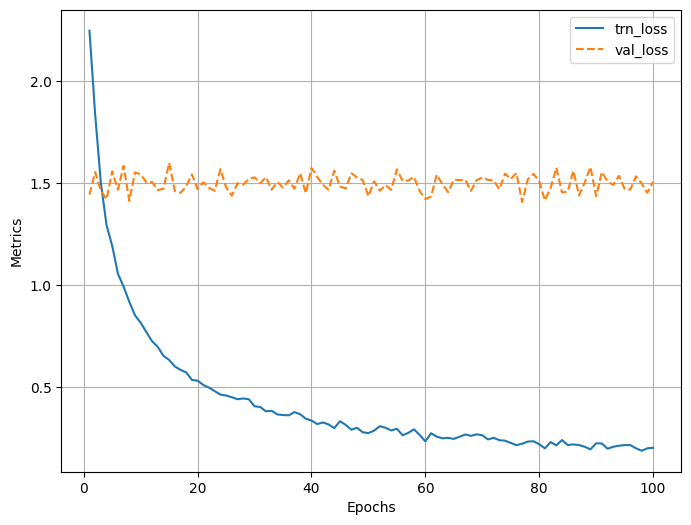

train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_loc_loss,█▆▄▃▂▃▂▂▂▃▂▂▁▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_loss,█▇▆▅▄▃▂▂▃▃▃▂▁▂▂▂▂▂▂▂▃▁▁▂▁▁▂▂▁▁▂▁▂▁▁▁▁▁▁▂
trn_loss_objectness,█▄▂▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_loss_rpn_box_reg,█▇▅▅▄▃▁▂▂▂▄▂▂▁▃▂▂▂▁▂▂▁▁▂▁▁▂▂▁▁▂▂▂▁▁▁▁▁▁▂
trn_regr_loss,█▇█▆▅▃▂▂▃▂▄▃▂▂▂▃▂▂▂▂▃▁▁▂▁▂▂▂▁▁▂▁▂▂▂▁▁▁▁▂
val_loc_loss,▃▂▃▁▂▆▁▁▁▃▂▂▂▃▃▂▁▁▂▂▂▃▁▁▂▁▂▃▂▂▂▂▁▂▂▁▄▂█▁
val_loss,▅▃▅▁▂▇▂▂▁▄▃▃▃▄▄▁▂▁▃▂▂▄▂▂▃▂▂▄▄▄▂▃▁▂▄▁▃▃█▁
val_loss_objectness,█▁▂▁▁▇▁▁▁▂▁▁▁▃█▁▁▁▂▁▁▅▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▂▅▁
val_loss_rpn_box_reg,█▃▄▂▁█▁▁▁▄▂▂▂▁▄▁▁▁▃▂▁▇▁▁▃▁▁▃▅▃▁▅▃▂▅▁▂▂▃▁
val_regr_loss,█▅█▁▄▆▃▂▁▆▄▅▄▅▅▁▄▂▃▃▃▅▃▃▆▃▄▇█▇▂▇▁▄▇▂▁▅▇▂


In [65]:
log = Report(epochs)
min_loss = 100


# Inside training loop
for e in range(epochs):
    epoch_loss = 0
    for i, batch in enumerate(tr_dl):
        N = len(tr_dl)
        loss, losses = train_batch(batch, model, optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_loss_objectness=loss_objectness.item(),
                   trn_loss_rpn_box_reg = loss_rpn_box_reg.item())
        # Log metrics with wandb
        wandb.log({
            'trn_loss': loss,
            'trn_loc_loss': loc_loss,
            'trn_regr_loss': regr_loss,
            'trn_loss_objectness': loss_objectness,
            'trn_loss_rpn_box_reg': loss_rpn_box_reg
        })
        epoch_loss += loss.item()


    epoch_loss /= len(tr_dl)
    if epoch_loss < min_loss:
        torch.save(model.state_dict(), checkpoint_file)
#        save_checkpoint(epoch=e, model=model, model_name=model_settings['backbone'], optimizer=optim, optimizer_name=model_settings['optimizer'])
    wandb.log({'train_loss': epoch_loss})
    print("Loss={0:.4f} in Epoch={1:d}".format(epoch_loss, e))

    log.report_avgs(e+1)

# validation loop
for e in range(epochs):
    # Validation loop
    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses = validate_batch(batch, model.float(), optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg',
                                                                   'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                   val_regr_loss=regr_loss.item(), val_loss_objectness=loss_objectness.item(),
                   val_loss_rpn_box_reg = loss_rpn_box_reg.item())
        # Log metrics with wandb
        wandb.log({
            'val_loss': loss,
            'val_loc_loss': loc_loss,
            'val_regr_loss': regr_loss,
            'val_loss_objectness': loss_objectness,
            'val_loss_rpn_box_reg': loss_rpn_box_reg
        })

    log.report_avgs(e+1)

log.plot_epochs(['trn_loss', 'val_loss'])
wandb.finish()

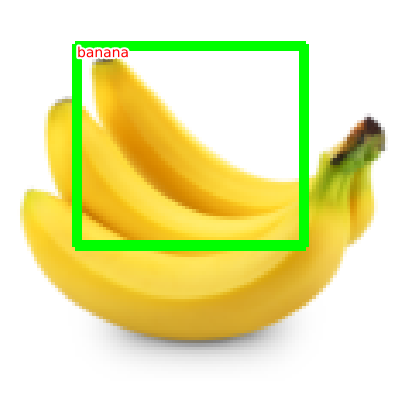

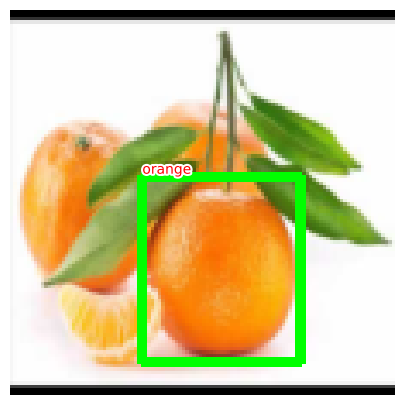

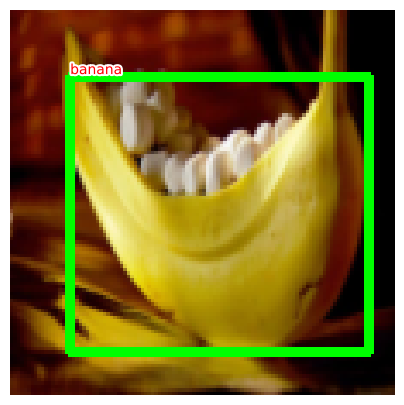

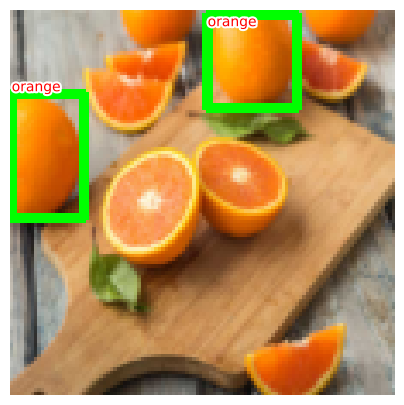

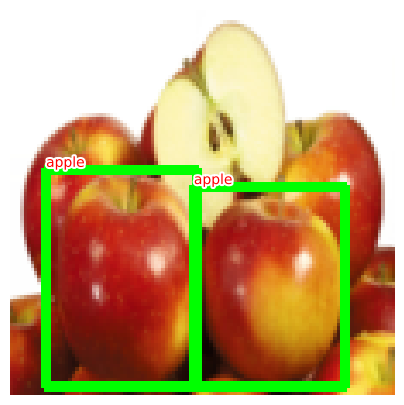

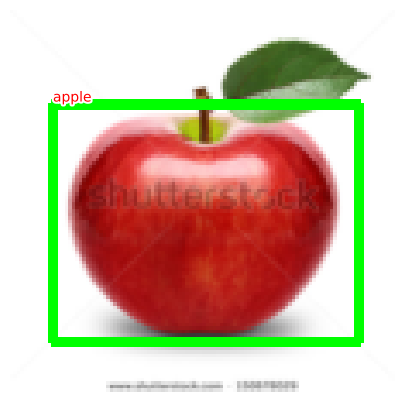

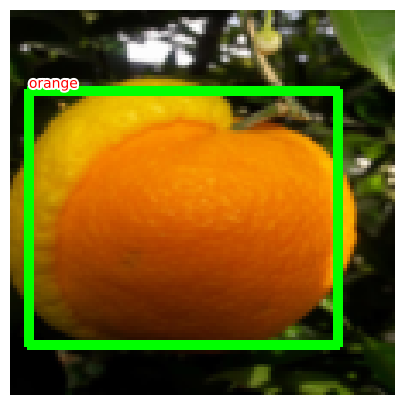

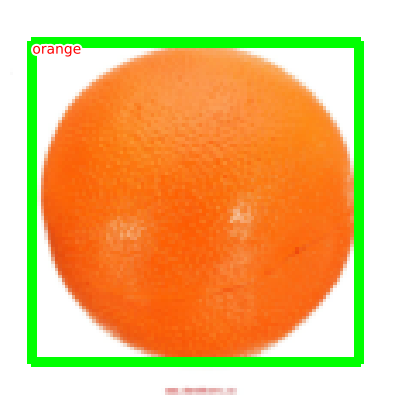

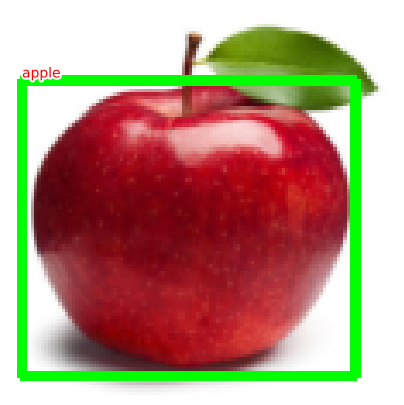

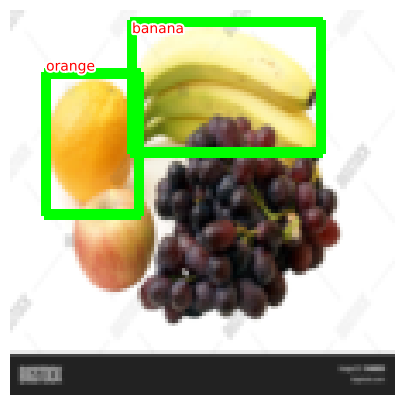

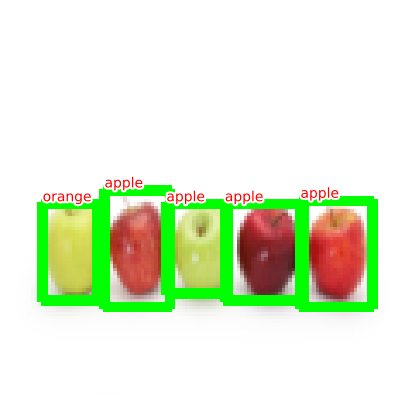

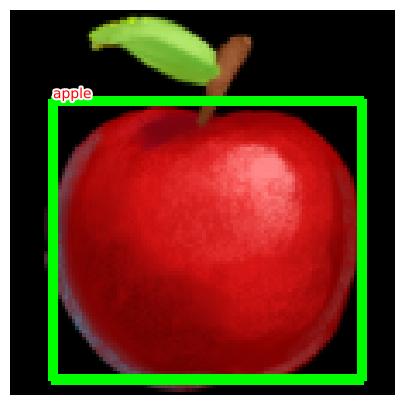

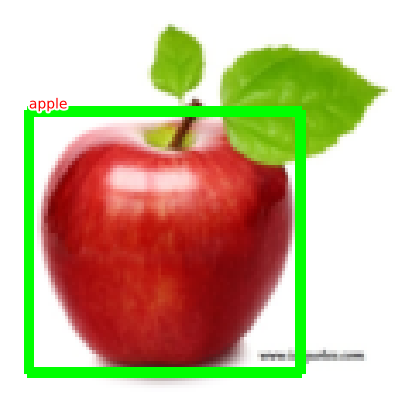

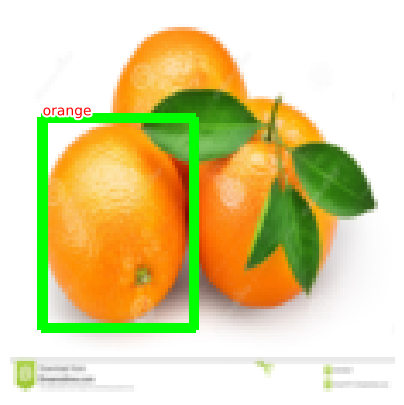

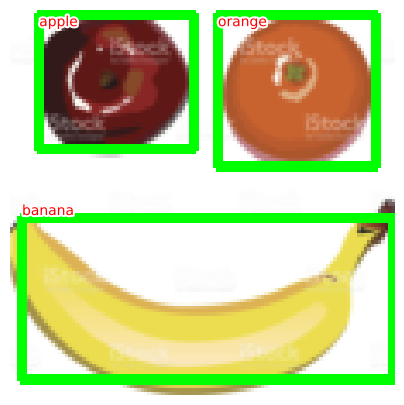

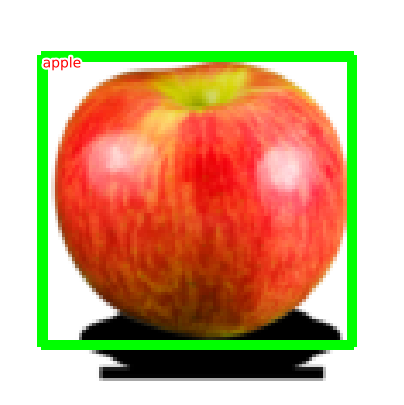

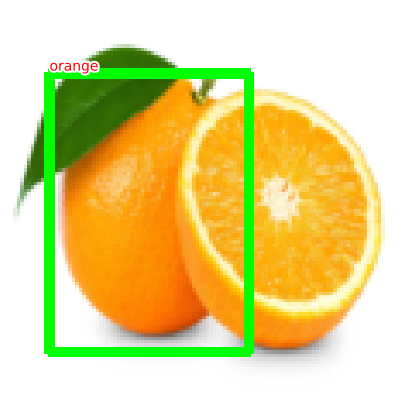

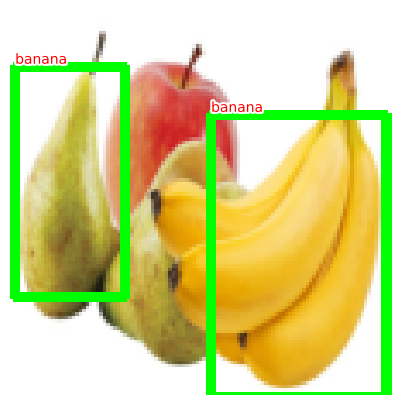

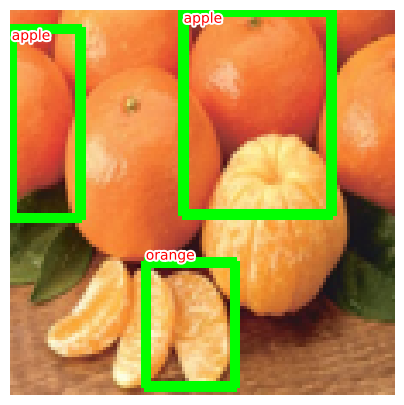

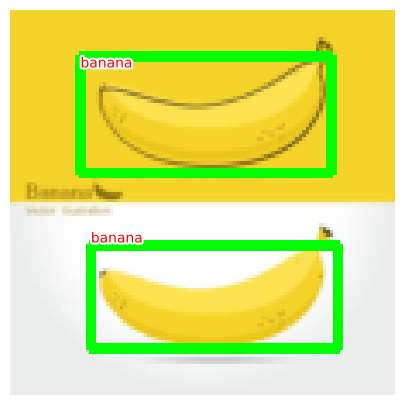

In [66]:
from torchvision.ops import nms

def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for i, (images, targets) in enumerate(val_dl):
    if i == 10: break
    images = [im for im in images]
    outputs = model(images)
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        show(images[i].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5, text_sz=10)